In [ ]:
### switch to parent folder in order to import functions
import os
os.chdir('..')
from pathlib import Path
from matplotlib import pyplot as plt
import json
import numpy as np
from lib.utils import dBm_gray, plot_dict, calc_loss_with_mask, print_metricsTest, gray_dBm
from lib.data_loading import load_env_inputs, load_gt_observations_from_dict, load_tx_inputs
import torch
from PIL import Image
from collections import defaultdict

# Load the data
- "old": measurements from 25/01, pure LoS
- "new": measurements from 25/11, some nLoS measurements as well

In [2]:
shape_target = (32, 32)
file_old = Path('./dataset/seminar_room_2501/measured_data.json')
file_new = Path('data_seminar_room/measured_data_2511.json')

with open(file_old, 'r') as f:
    data_old = json.load(f)
with open(file_new, 'r') as f:
    data_new  = json.load(f)

data_new_mit = {t : {m : md for m, md in td.items() if 'mit' in m and not 'Widerholung' in m} for t, td in data_new.items()}    
data_new_ohne = {t : {m : md for m, md in td.items() if 'ohne' in m and not 'Widerholung' in m} for t, td in data_new.items()}    



In [3]:
print(data_old["Tx1"].keys())
print(data_new_ohne["Tx1"].keys())
print(data_new_mit["Tx1"].keys())

dict_keys(['MeasurementArea_1', 'MeasurementArea_2', 'MeasurementArea_3', 'MeasurementArea_4', 'MeasurementArea_5', 'MeasurementArea_6', 'MeasurementArea_7', 'MeasurementArea_8'])
dict_keys(['MeasurementArea_5-ohne_Abschattung', 'MeasurementArea_6-ohne_Abschattung-Wiederholung1', 'MeasurementArea_6-ohne_Abschattung'])
dict_keys(['MeasurementArea_5-mit_Abschattung', 'MeasurementArea_5-mit_Abschattung-Wiederholung1', 'MeasurementArea_6-mit_Abschattung'])


## Plot


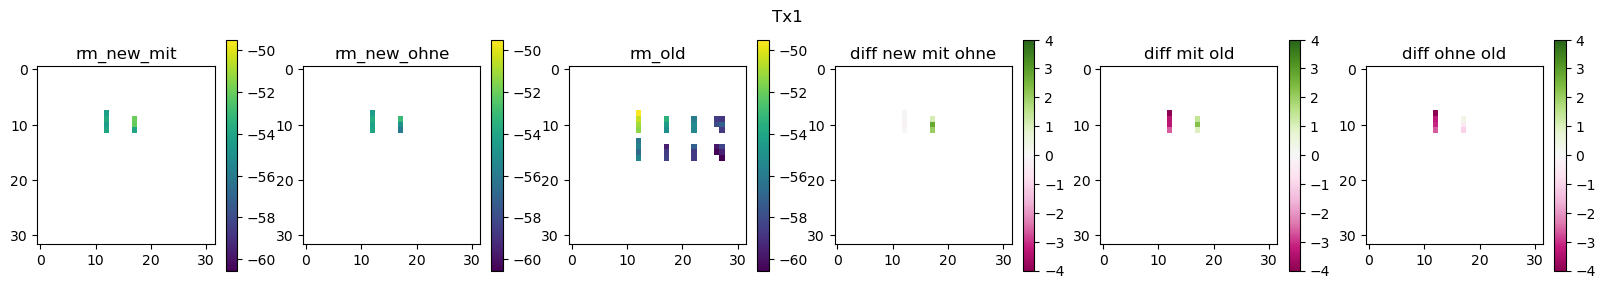

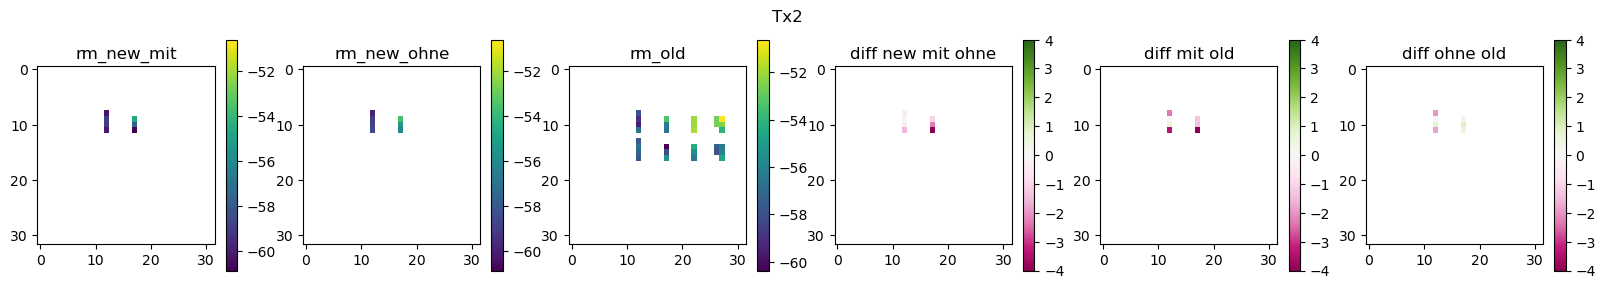

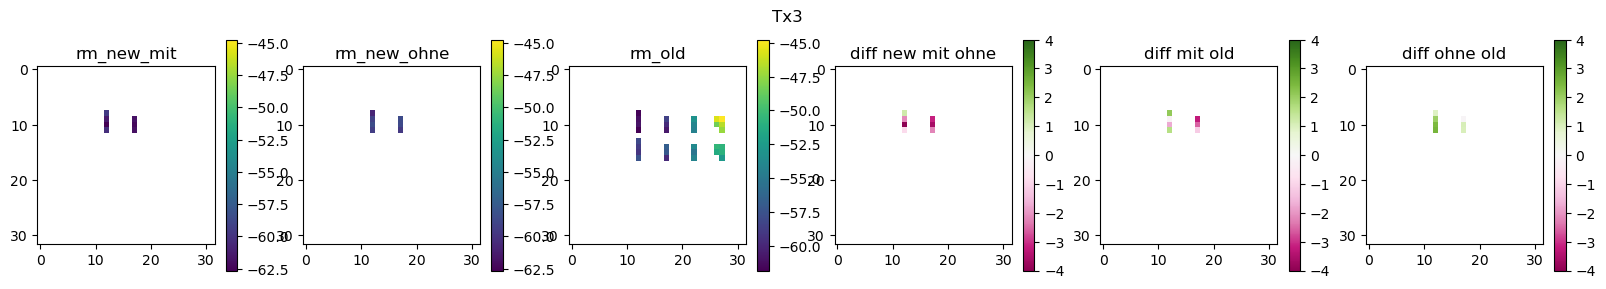

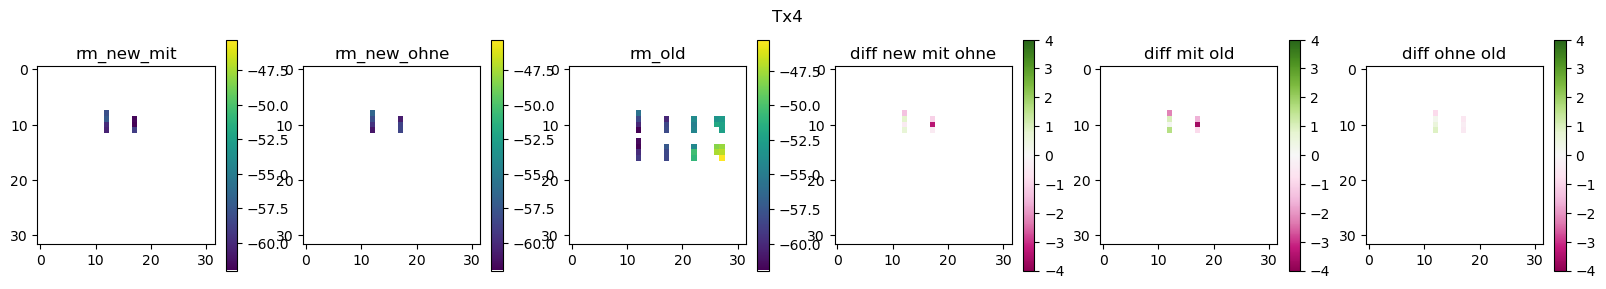

In [4]:
percentage_thresh = 50
for tx in data_old.keys():
    rm_new_mit, rm_new_ohne, rm_old = np.full(shape=shape_target, fill_value=np.nan), np.full(shape=shape_target, fill_value=np.nan), np.full(shape=shape_target, fill_value=np.nan)
    # for meas_area_name, meas_area_values in data1[tx].items():
    for meas_area_name, meas_area_values in data_new[tx].items():
        if 'Widerholung' in meas_area_name:
            continue
        for point_data in meas_area_values.values():
            if point_data['percentage_samples_available'] < percentage_thresh:
                continue
            else:
                if 'mit' in meas_area_name:
                    rm_new_mit[*point_data['coordinates']] = point_data ['pl']
                elif 'ohne' in meas_area_name:
                    rm_new_ohne[*point_data['coordinates']] = point_data ['pl']
                else:
                    print(f'{meas_area_name=} ??')
    for meas_area_name, meas_area_values in data_old[tx].items():
        for point_data in meas_area_values.values():
            if point_data['percentage_samples_available'] < percentage_thresh:
                continue
            else:
                rm_old[*point_data['coordinates']] = point_data ['pl']
    
    vmin, vmax = min(np.nanmin(r) for r in [rm_new_mit, rm_new_ohne, rm_old]), max(np.nanmax(r) for r in [rm_new_mit, rm_new_ohne, rm_old])
    fig = plt.figure(figsize=(20, 3))
    fig.add_subplot(161)
    plt.imshow(rm_new_mit, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title('rm_new_mit')
    
    fig.add_subplot(162)
    plt.imshow(rm_new_ohne, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title('rm_new_ohne')
    
    fig.add_subplot(163)
    plt.imshow(rm_old)#, cmap='PiYG', vmin=-4, vmax=4)
    plt.colorbar()
    plt.title('rm_old')

    fig.add_subplot(164)
    plt.imshow(rm_new_mit - rm_new_ohne, cmap='PiYG', vmin=-4, vmax=4)
    plt.colorbar()
    plt.title('diff new mit ohne')
    
    fig.add_subplot(165)
    plt.imshow(rm_new_mit - rm_old, cmap='PiYG', vmin=-4, vmax=4)
    plt.colorbar()
    plt.title('diff mit old')
    
    fig.add_subplot(166)
    plt.imshow(rm_new_ohne - rm_old, cmap='PiYG', vmin=-4, vmax=4)
    plt.colorbar()
    plt.title('diff ohne old')

    plt.suptitle(f'{tx}')


# Testing

## Load into tensors, like during training

In [5]:
tx_file = Path('./dataset/seminar_room_2501/raster_seminar_room_256/projectwi_files_tx.json')
with open(tx_file, 'r') as f:
    tx_coords_dict = json.load(f)

pl_trnc = -71
pl_max = -12

def extract_data(observation_areas : list, test_areas : list, percentage_threshold : float, tx_id : int, seed : int):
    n_obs_points = sum(len(d[1]) for d in observation_areas)
    rng = np.random.default_rng(seed=seed)
    point_ids = rng.integers(low=0, high=20, size=n_obs_points)
    point_idx = 0

    obs_inp = np.ones((32, 32)) * (-500)
    for data_dict, obs_area_list in observation_areas:
        for obs_area in obs_area_list:
            tx_data = data_dict[f"Tx{tx_id}"][obs_area].values()
            points_usable = [point_data for point_data in tx_data if point_data["percentage_samples_available"] > percentage_threshold]
            # print(f'\n\n{point_ids[point_idx]=}\n{type(tx_data)=}\t{tx_data=}\n{len(tx_data)=}\t\t{len(points_usable)=}')
            try:
                point_used = points_usable[point_ids[point_idx]%len(points_usable)]
            except:
                print(f'{point_ids = }\n{point_idx = }\n{points_usable = }\n{len(points_usable)=}\n{point_idx%len(points_usable)=}')
                raise Exception('stop')
            assert obs_inp[*point_used['coordinates']] == -500, f'{point_used=} already appears in obs_inp?'
            obs_inp[*point_used['coordinates']] = point_used['pl']
            point_idx += 1

    obs_inp = torch.tensor(dBm_gray(obs_inp, pl_trnc=-71, pl_max=-12, clip=True))
    obs_mask = obs_inp > 0

    gt = np.ones((32, 32)) * (-500)
    for data_dict, obs_area_list in test_areas:
        for obs_area in obs_area_list:
            tx_data = data_dict[f"Tx{tx_id}"][obs_area].values()
            for point_data in tx_data:
                if point_data["percentage_samples_available"] > percentage_threshold:
                    assert gt[*point_data['coordinates']] == -500, f'{gt[*point_data["coordinates"]]=}'
                    if obs_mask[*point_data['coordinates']] > 0:
                        continue
                    gt[*point_data['coordinates']] = point_data["pl"]
    gt = torch.tensor(dBm_gray(gt, pl_trnc=pl_trnc, pl_max=pl_max, clip=True))
    gt_mask = gt > 0

    return obs_inp.unsqueeze(0).unsqueeze(0), gt.unsqueeze(0).unsqueeze(0), gt_mask.unsqueeze(0).unsqueeze(0), obs_mask.unsqueeze(0).unsqueeze(0), torch.tensor(tx_coords_dict[str(tx_id - 1)]).unsqueeze(0)



def get_model_inputs(config, tx_id, obs_inp, dataset_dir):
    with open(Path(config['dataset_dir']) / config['env_raster_subdir']  / 'rasterization_parameters.json', 'r') as f:
        raster_params = json.load(f)
    n_classes = len(raster_params['materials']) + 1
    raster_heights = raster_params['heights']
    x_steps = raster_params['x_steps']
    y_steps = raster_params['y_steps']
    x_step_size = raster_params['x_max'] / raster_params['x_steps']
    y_step_size = raster_params['y_max'] / raster_params['y_steps']
    env_id = 'wi_files'


    inputs_cnn = torch.empty((0, x_steps, y_steps))
    if config.get('use_material_properties', False) or config.get('use_material_classes', True):
        inputs_cnn = load_env_inputs(
            inputs=inputs_cnn, 
            env_id_here=env_id, 
            env_raster_subdir=dataset_dir / (f'raster_seminar_room_256' if not 'bin' in config['env_raster_subdir'] else 'raster_seminar_room_256_bin'), 
            raster_heights=raster_heights, 
            n_classes=n_classes, 
            use_material_classes=config.get('use_material_classes', True), 
            use_material_properties=config.get('use_material_properties', False)
        )

    inputs_cnn = torch.concat([inputs_cnn, torch.repeat_interleave(torch.repeat_interleave(obs_inp.squeeze(0), 8, -1), 8, -2)])

    # Load transmitter inputs
    inputs_cnn, _ = load_tx_inputs(
        env_tx_subdir=dataset_dir / f'raster_seminar_room_256',
        env_id_here=env_id,
        tx_id=tx_id - 1,
        use_tx_one_hot=config['use_tx_one_hot'],
        inputs=inputs_cnn,
        x_step_size=x_step_size,
        y_step_size=y_step_size,
        use_tx_distance=config['use_tx_distance'],
        use_Tx_distToRx=config['use_Tx_distToRx'],
        rx_height=1,
        use_log_distance=config['use_log_distance'],
        use_fspl=config['use_fspl'],
        frequency_hz=5.82e9,
        return_coords=True,
        pl_max=pl_max,
        pl_trnc=pl_trnc,
    ) # type: ignore

    return inputs_cnn.to(torch.float32).unsqueeze(0)

torch.Size([1, 1, 32, 32]) torch.Size([1, 1, 32, 32]) torch.Size([1, 1, 32, 32]) torch.Size([1, 1, 32, 32])


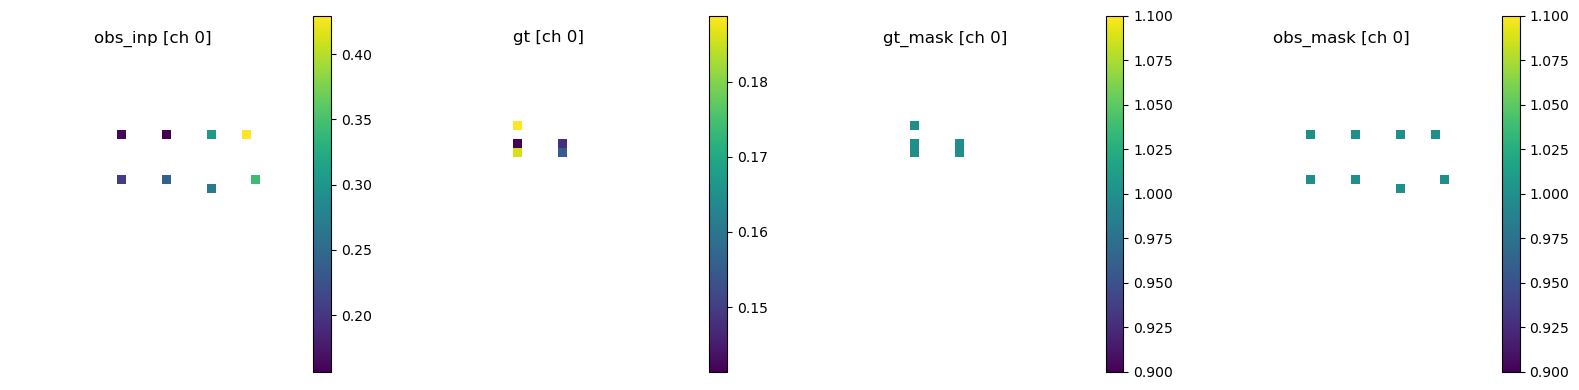

In [6]:
tx_id = 3

obs_inp, gt, gt_mask, obs_mask, tx_coords = extract_data(
    # observation_areas=[(data_old, [f'MeasurementArea_{k}' for k in [1,2,3,4,7,8]])],
    # test_areas=[(data_old, [f'MeasurementArea_{k}' for k in [5, 6]])],
    # test_areas=[(data_new_mit, [f'MeasurementArea_{k}-mit_Abschattung' for k in [5, 6]])],
    observation_areas=[(data_old, [f'MeasurementArea_{k}' for k in [1,2,3,4,7,8]]),
                        (data_new_mit, [f'MeasurementArea_{k}-mit_Abschattung' for k in [5, 6]])
                        ],
    # test_areas=[(data_old, [f'MeasurementArea_{k}' for k in [5, 6]])],
    test_areas=[(data_new_mit, [f'MeasurementArea_{k}-mit_Abschattung' for k in [5, 6]])],
    percentage_threshold=50,
    tx_id=tx_id,
    seed=0
)
print(obs_inp.shape, gt.shape, gt_mask.shape, obs_mask.shape)
plot_dict(dict(obs_inp=obs_inp, gt=gt, gt_mask=gt_mask, obs_mask=obs_mask), in_batch_id=0, close_fig=False)

## Test all methods

In [7]:
from script_baselines_measurements import calculate_fspl_with_offset, rbf_interpolate, tps_interpolate
from script_rt_measurements import get_rm_adjusted
from lib.modulesIPPNet import RadioNetAnySize

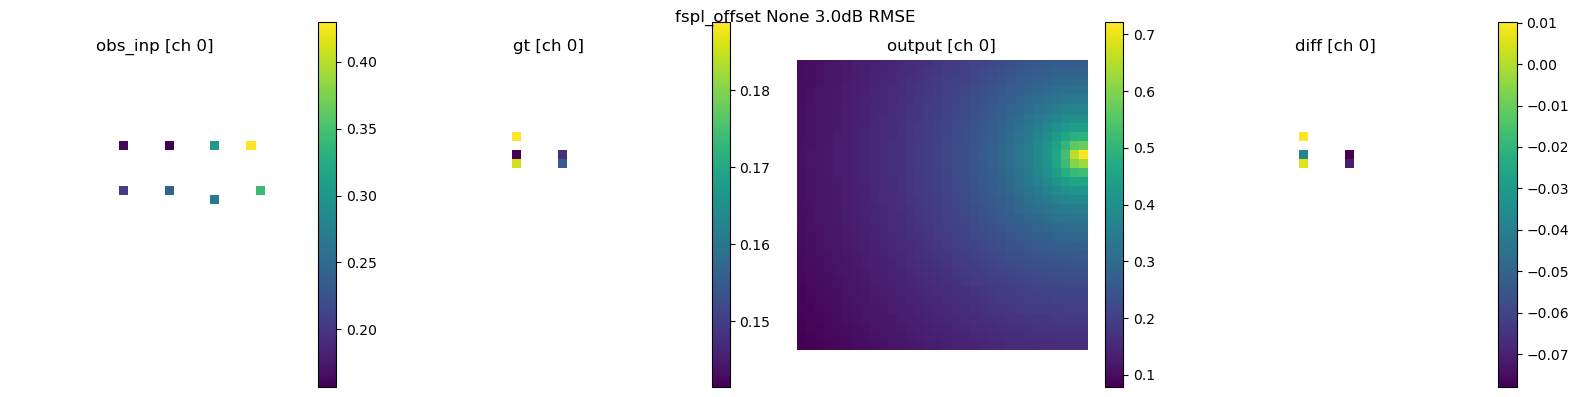

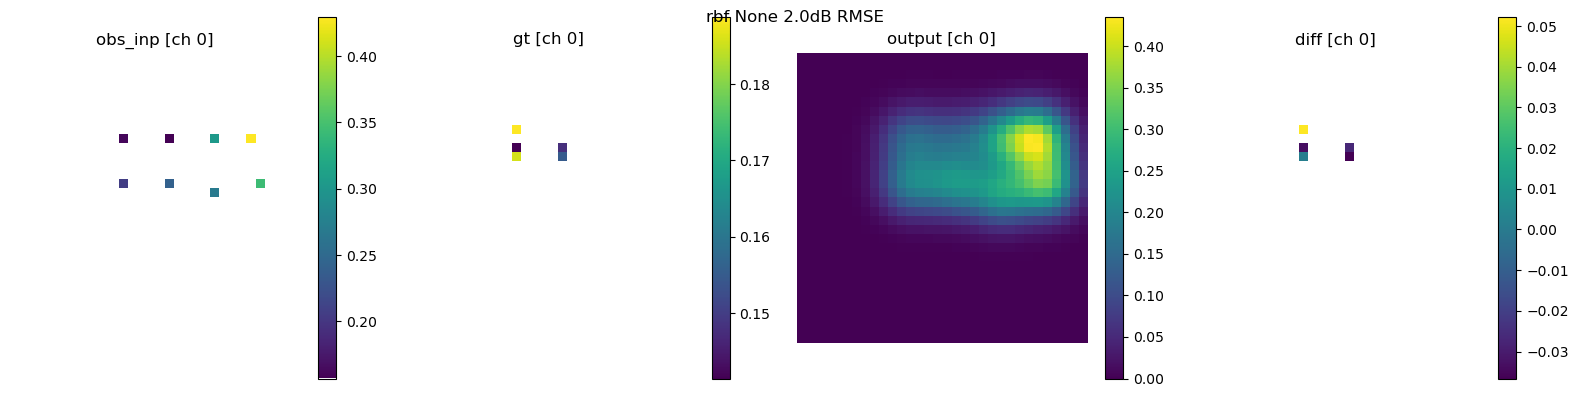

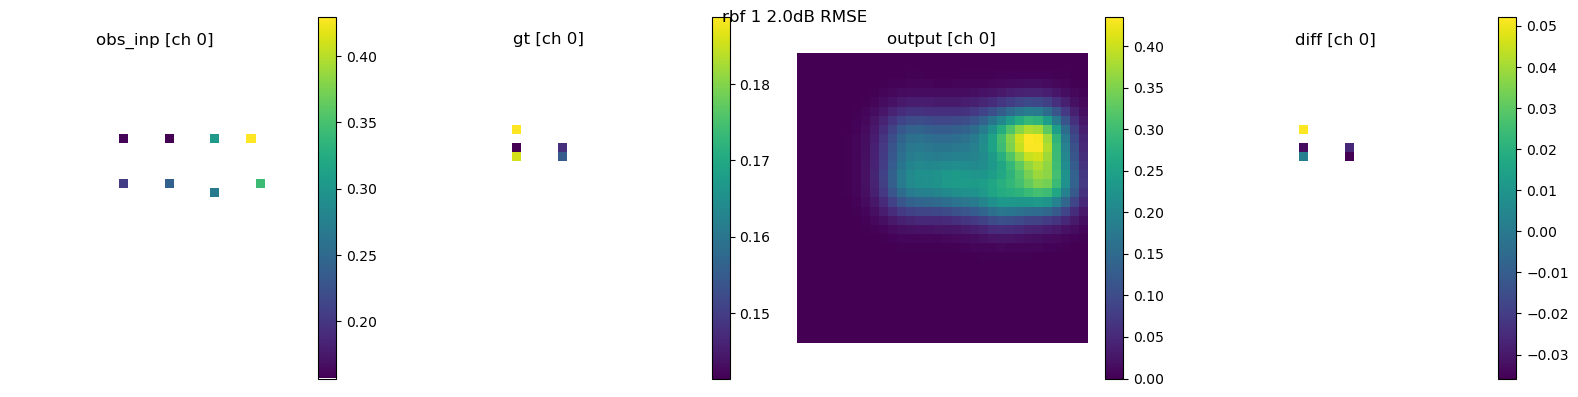

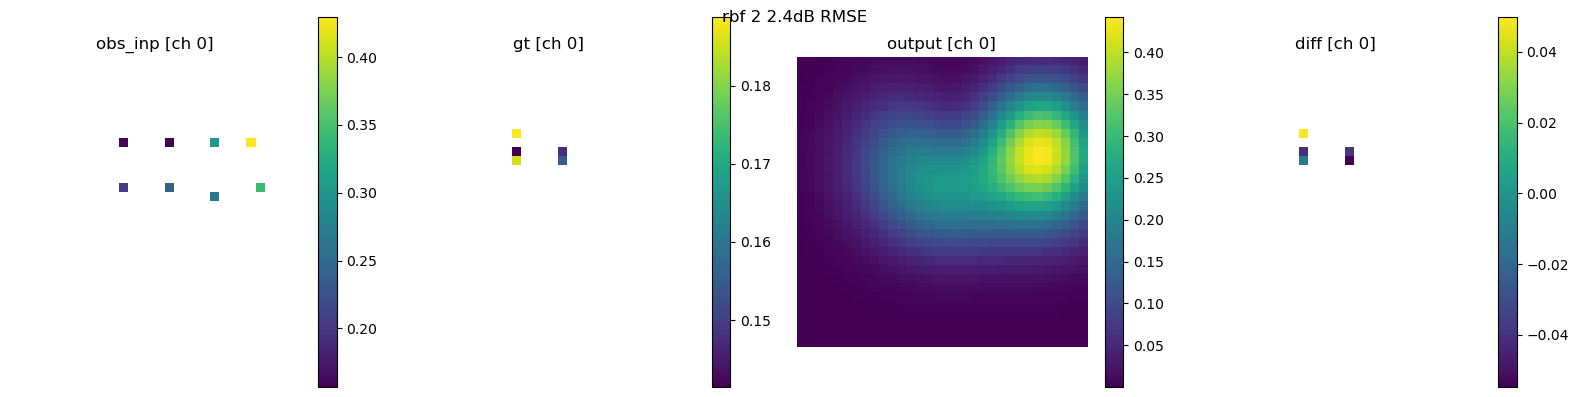

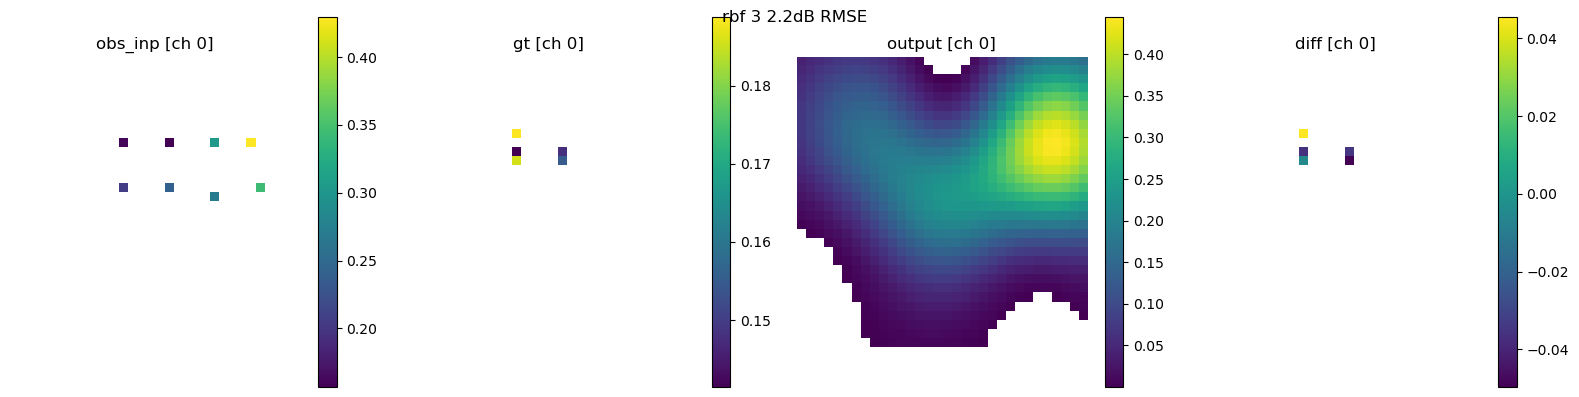

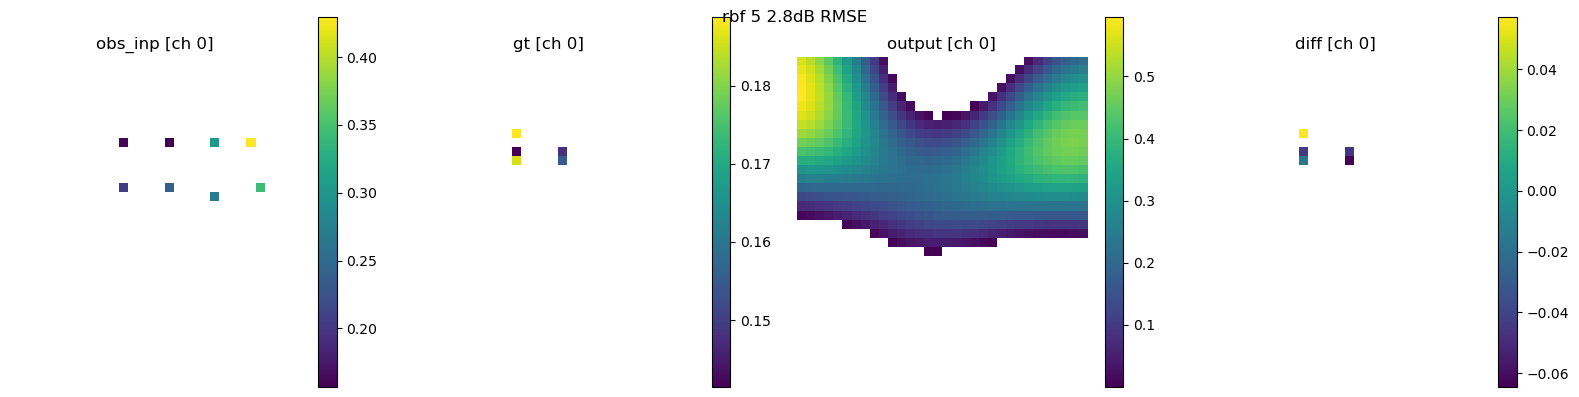

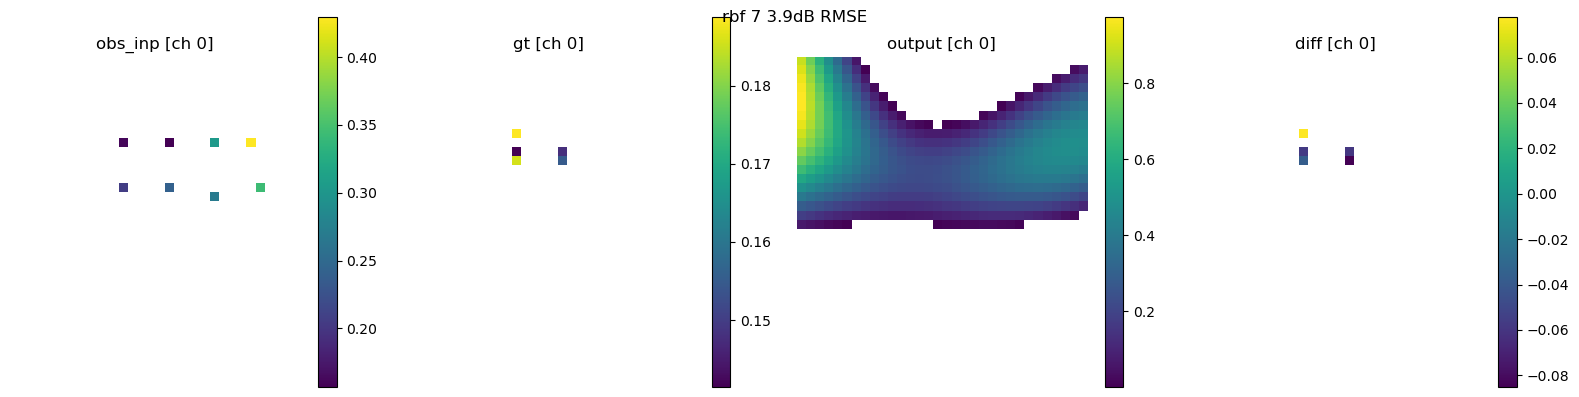

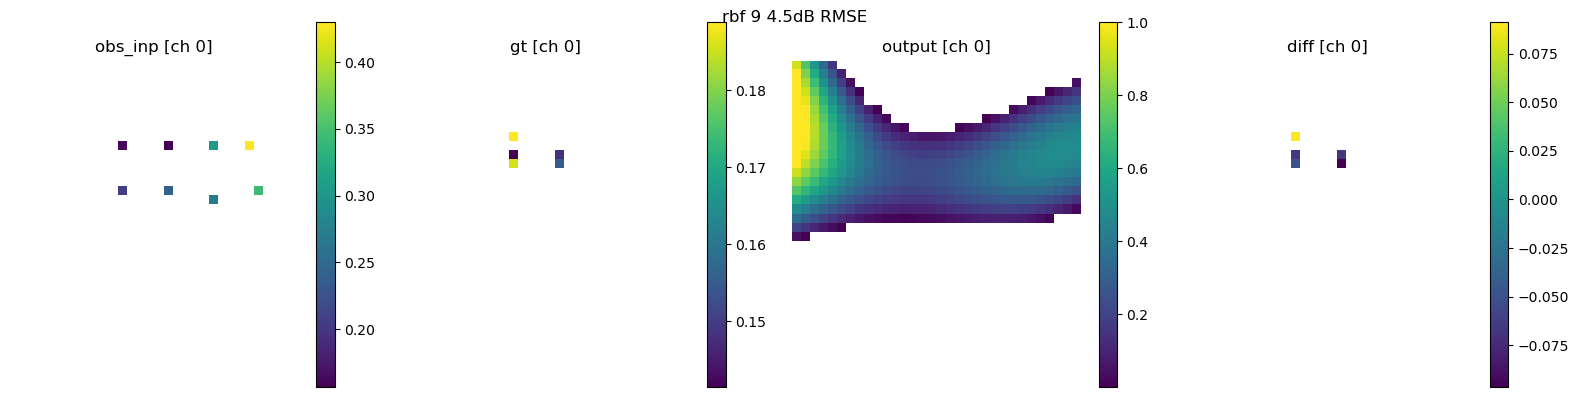

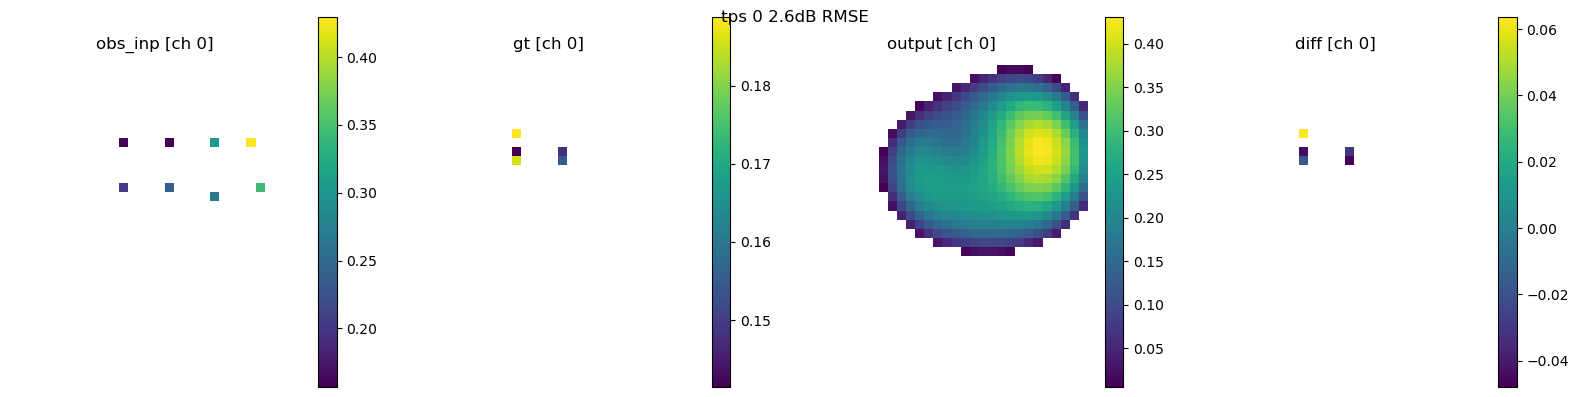

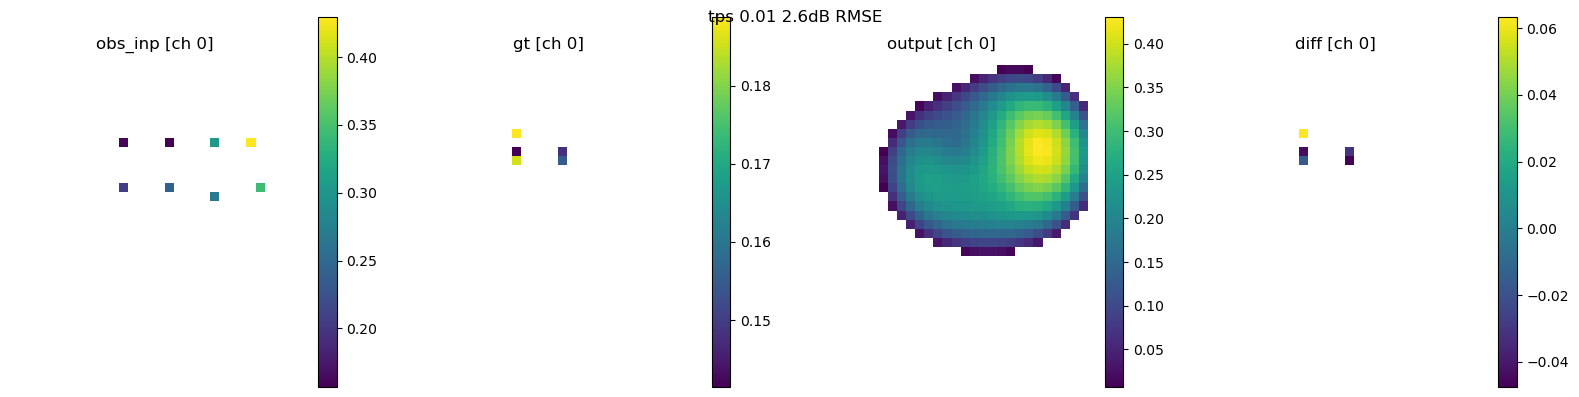

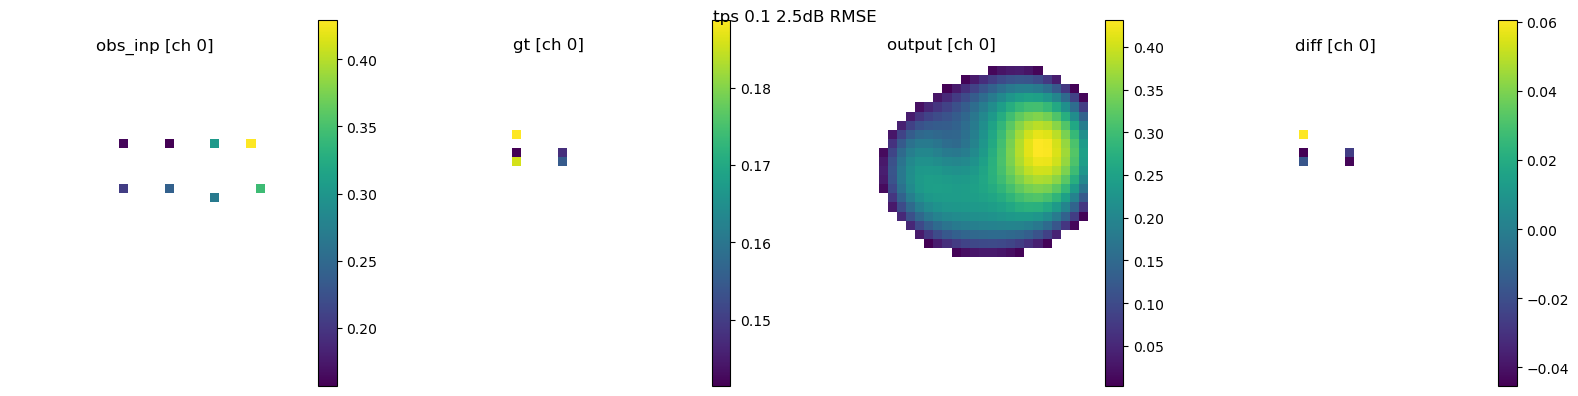

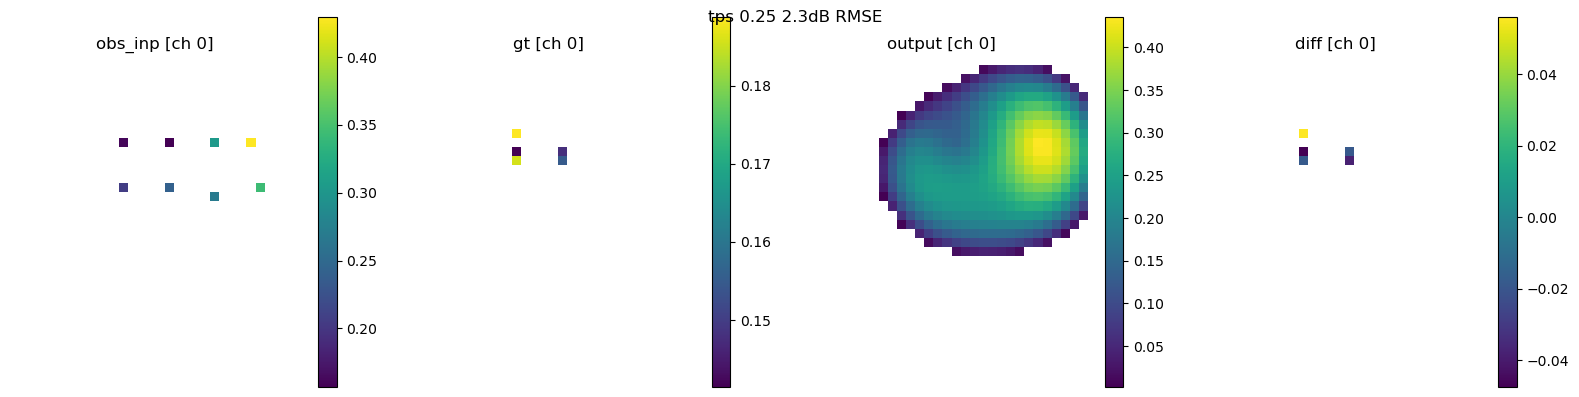

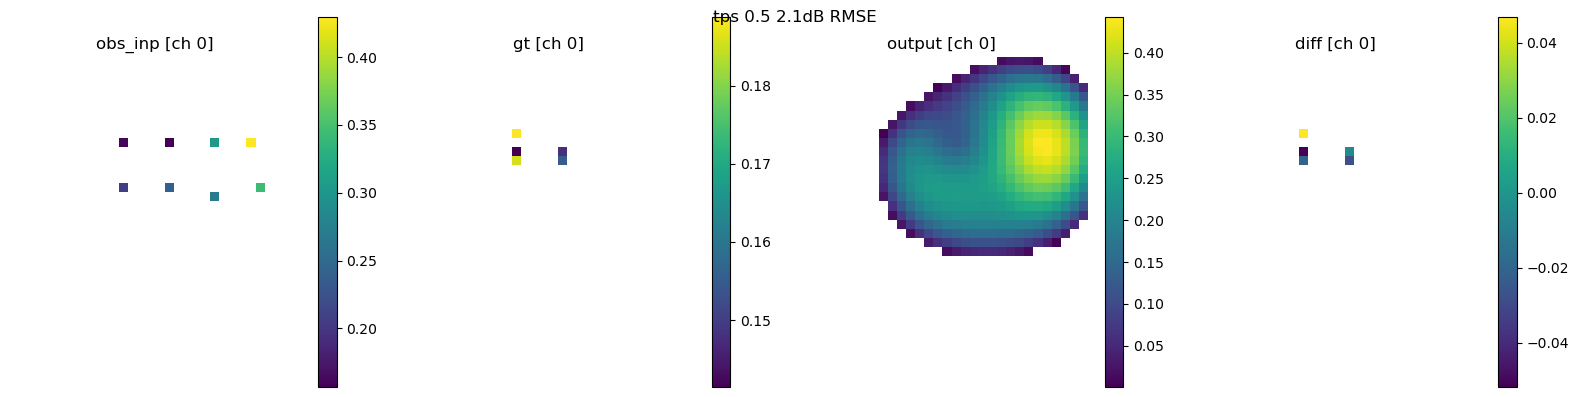

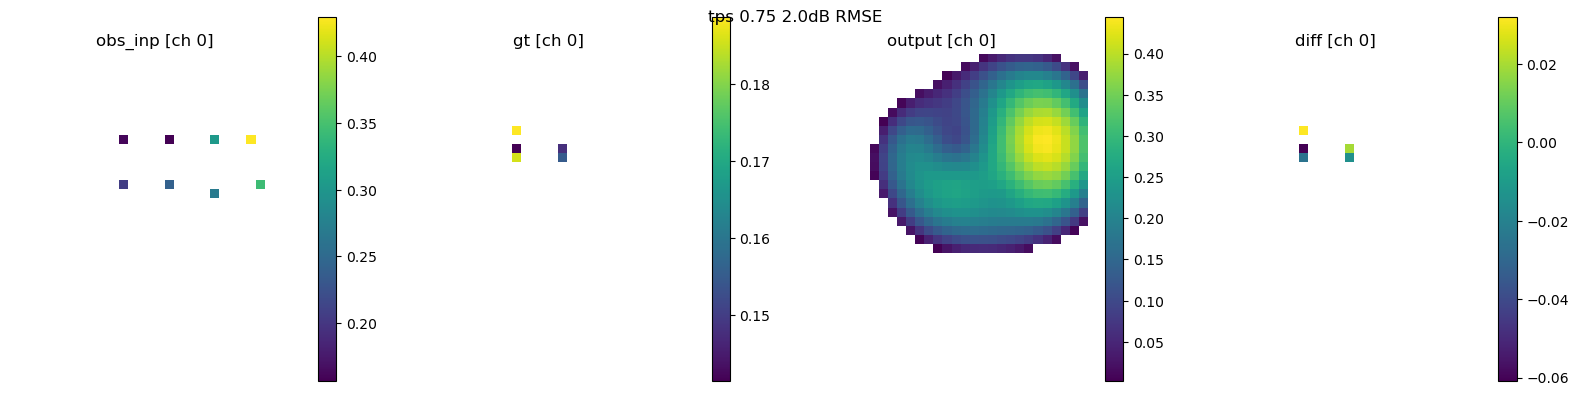

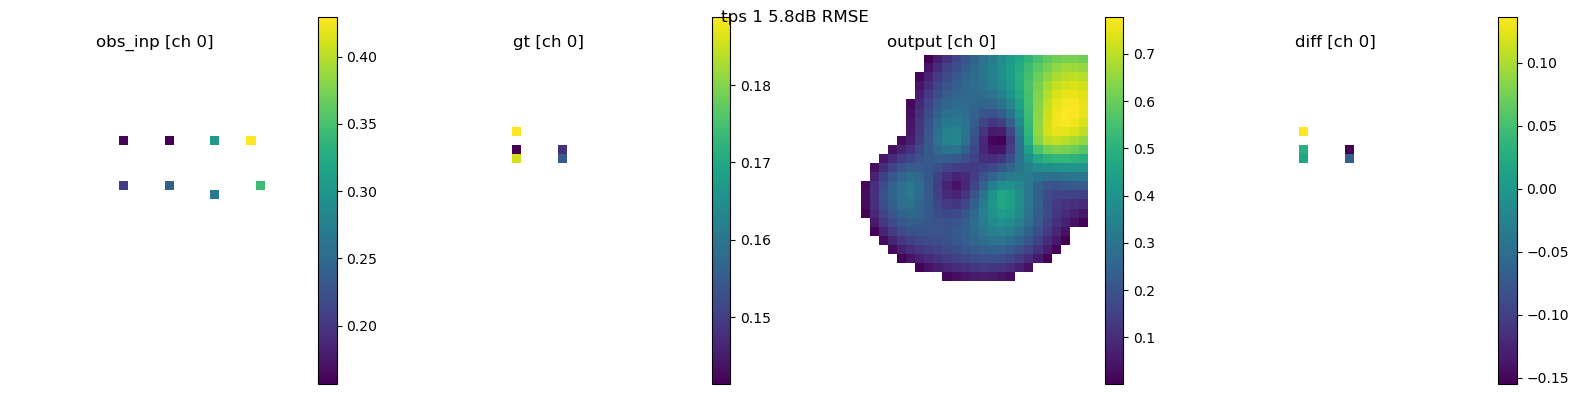

In [8]:
methods = {
    'fspl_offset' : (calculate_fspl_with_offset, [None]), 
    'rbf' : (rbf_interpolate, [None, 1, 2, 3, 5, 7, 9]), 
    'tps' : (tps_interpolate, [0, 0.01, 0.1, 0.25, 0.5, 0.75, 1])
}
for name, (fun, param_list) in methods.items():
    for param in param_list:
        output = fun(inputs=obs_inp, observation_mask=obs_mask, tx_coords=tx_coords, pl_trnc=pl_trnc, pl_max=pl_max, param=param)
        diff = (gt - output) * gt_mask
        err = calc_loss_with_mask(pred=output, target=gt, mask=gt_mask, observation_mask=obs_mask, alpha=1, metrics=None)
        plot_dict(dict(obs_inp=obs_inp, gt=gt, output=output, diff=diff), in_batch_id=0, close_fig=False, suptitle=f'{name} {param} {torch.sqrt(err) * (71-12):.1f}dB RMSE')

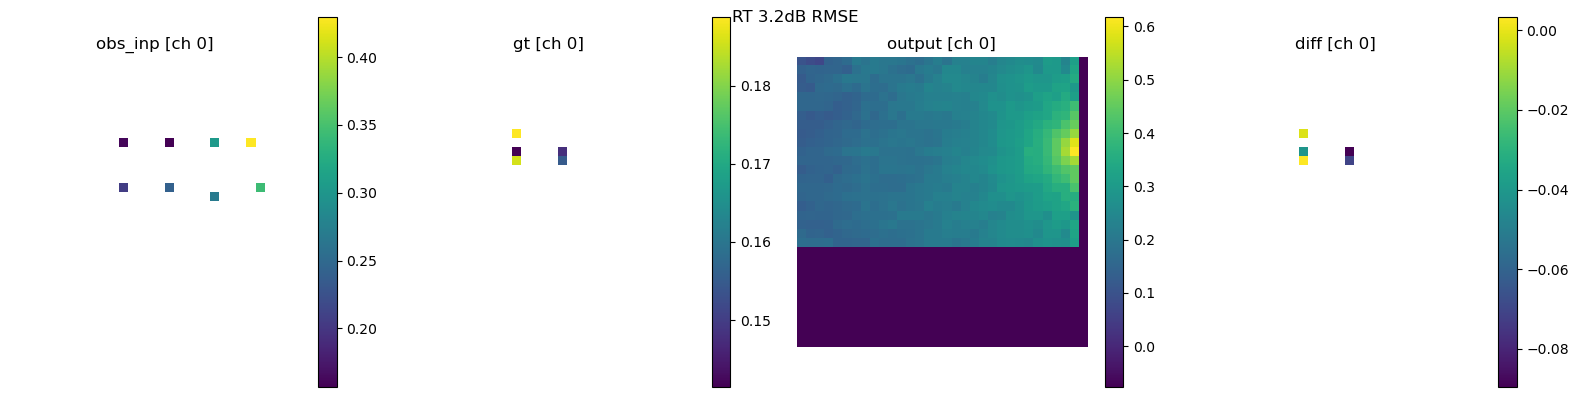

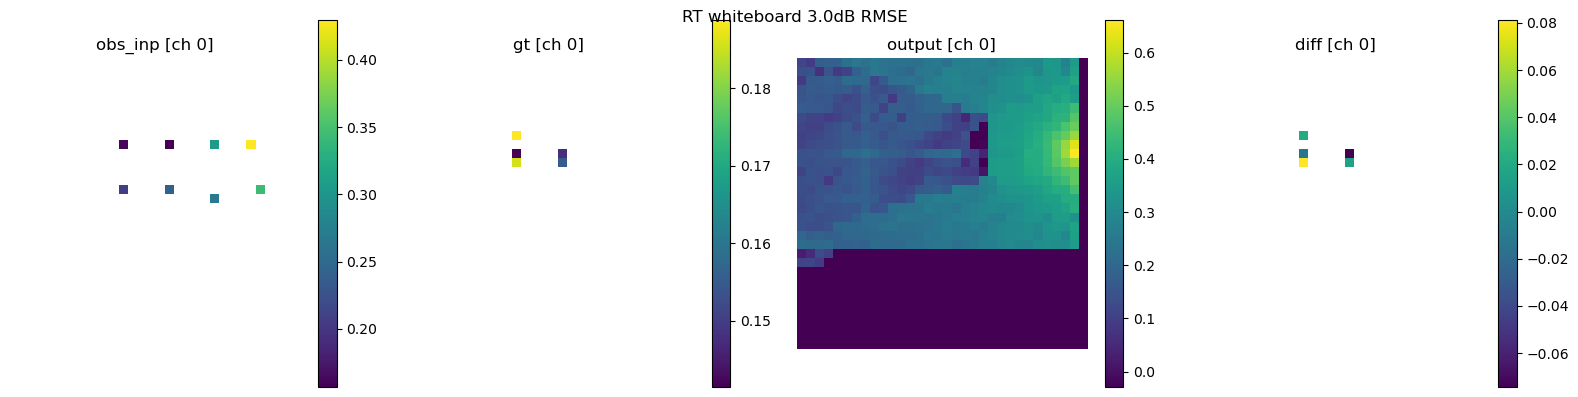

In [9]:
sim_output_dir = Path('dataset/seminar_room_2501')
rms_rt_np = {tx : np.zeros((32, 32)) for tx in range(1, 5)}
rms_rt = {}
for tx in rms_rt_np.keys():
    img = np.array(Image.open(sim_output_dir / f'sim_{tx=}.png')) / 255
    rms_rt_np[tx][:img.shape[0], :img.shape[1]] = img
    rms_rt[tx] = torch.Tensor(rms_rt_np[tx]).unsqueeze(0)

sim_output_dir_whiteboard = Path('dataset/seminar_room_2511_wb')
rms_rt_np_whiteboard = {tx : np.zeros((32, 32)) for tx in range(1, 5)}
rms_rt_whiteboard = {}
for tx in rms_rt_np.keys():
    img = np.array(Image.open(sim_output_dir_whiteboard / f'sim_{tx=}.png')) / 255
    rms_rt_np_whiteboard[tx][:img.shape[0], :img.shape[1]] = img
    rms_rt_whiteboard[tx] = torch.Tensor(rms_rt_np_whiteboard[tx]).unsqueeze(0)


output = get_rm_adjusted(inputs=obs_inp, observation_mask=obs_mask, rm=rms_rt[tx_id])
diff = (gt - output) * gt_mask
err = calc_loss_with_mask(pred=output, target=gt, mask=gt_mask, observation_mask=obs_mask, alpha=1, metrics=None)
plot_dict(dict(obs_inp=obs_inp, gt=gt, output=output, diff=diff), in_batch_id=0, close_fig=False, suptitle=f'RT {torch.sqrt(err) * (71-12):.1f}dB RMSE')

output_whiteboard = get_rm_adjusted(inputs=obs_inp, observation_mask=obs_mask, rm=rms_rt_whiteboard[tx_id])
diff = (gt - output_whiteboard) * gt_mask
err = calc_loss_with_mask(pred=output_whiteboard, target=gt, mask=gt_mask, observation_mask=obs_mask, alpha=1, metrics=None)
plot_dict(dict(obs_inp=obs_inp, gt=gt, output=output_whiteboard, diff=diff), in_batch_id=0, close_fig=False, suptitle=f'RT whiteboard {torch.sqrt(err) * (71-12):.1f}dB RMSE')



In [10]:
# model_dir = Path('logs/RadioNetAnySize/20251005-12:14:48') # classes, pert, 1%
model_dir = Path('logs/RadioNetAnySize/20251210-12:17:45') # bin, pert
# model_dir = Path('logs/RadioNetAnySize/20251210-12:17:36') # bin, no pert
# model_dir = Path('logs/RadioNetAnySize/20251110-12:24:11') #  'Classes, No Perturbations'
# model_dir = Path('logs/RadioNetAnySize/20251110-12:25:12') # 'No Environment'
# model_dir = Path('logs/RadioNetAnySize/20251110-12:23:46') # classes, pert
weights = torch.load(model_dir / 'BestModel.pt', weights_only=True)
for k, v in weights.items():
    if not 'conv' in k:
        continue
    else:
        in_ch = v.shape[1]
        break

with open(model_dir / 'parameters.json', 'r') as f:
    config = json.load(f)

model = RadioNetAnySize(inputs=in_ch, initial_downsampling=int(config['raster_size'] / 32))
model.load_state_dict(weights)

<All keys matched successfully>

## CNN without whiteboard knowledge

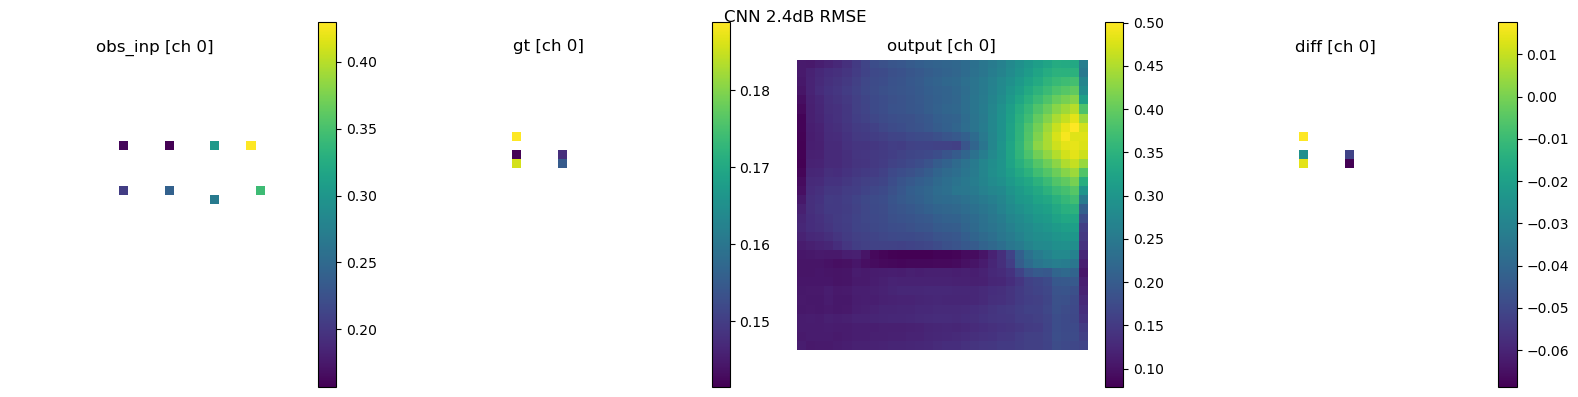

In [11]:
inputs_cnn = get_model_inputs(config, tx_id, obs_inp, dataset_dir=Path('dataset/seminar_room_2501'))
output_cnn = model(inputs_cnn)
diff = (gt - output_cnn) * gt_mask
err = calc_loss_with_mask(pred=output_cnn, target=gt, mask=gt_mask, observation_mask=obs_mask, alpha=1, metrics=None)
plot_dict(dict(obs_inp=obs_inp, gt=gt, output=output_cnn, diff=diff), in_batch_id=0, close_fig=False, suptitle=f'CNN {torch.sqrt(err) * (71-12):.1f}dB RMSE')

## With whiteboard

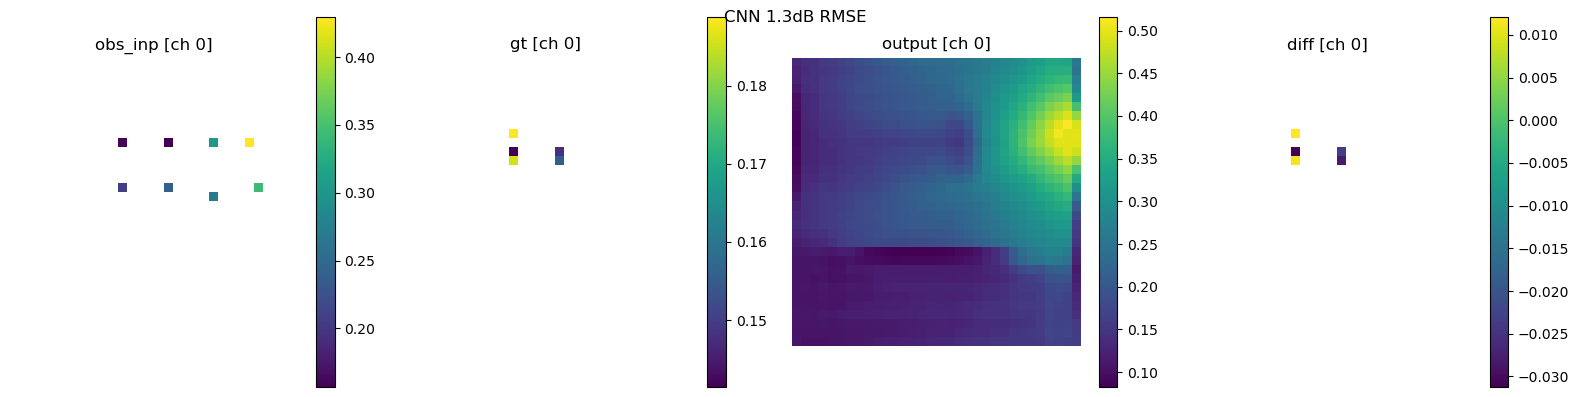

In [12]:
inputs_cnn = get_model_inputs(config, tx_id, obs_inp, dataset_dir=Path('dataset/seminar_room_2511_wb'))
output_cnn = model(inputs_cnn)
diff = (gt - output_cnn) * gt_mask
err = calc_loss_with_mask(pred=output_cnn, target=gt, mask=gt_mask, observation_mask=obs_mask, alpha=1, metrics=None)
plot_dict(dict(obs_inp=obs_inp, gt=gt, output=output_cnn, diff=diff), in_batch_id=0, close_fig=False, suptitle=f'CNN {torch.sqrt(err) * (71-12):.1f}dB RMSE')

# Now in a Loop to generate some statistics of errors


name='fspl_offset'	param=None
test: squared_errors_summed: 0.011117, valid_pixels_summed: 5.000000, loss: 0.002223, RMSE in dB: 2.781966

name='rbf'	param=None
test: squared_errors_summed: 0.012314, valid_pixels_summed: 5.000000, loss: 0.002463, RMSE in dB: 2.927988

name='rbf'	param=1
test: squared_errors_summed: 0.012623, valid_pixels_summed: 5.000000, loss: 0.002525, RMSE in dB: 2.964511

name='rbf'	param=2
test: squared_errors_summed: 0.010120, valid_pixels_summed: 5.000000, loss: 0.002024, RMSE in dB: 2.654384

name='rbf'	param=3
test: squared_errors_summed: 0.007644, valid_pixels_summed: 5.000000, loss: 0.001529, RMSE in dB: 2.306875

name='rbf'	param=5
test: squared_errors_summed: 0.009713, valid_pixels_summed: 5.000000, loss: 0.001943, RMSE in dB: 2.600374

name='rbf'	param=7
test: squared_errors_summed: 0.015342, valid_pixels_summed: 5.000000, loss: 0.003068, RMSE in dB: 3.268201

name='rbf'	param=9
test: squared_errors_summed: 0.021057, valid_pixels_summed: 5.000000, loss: 0

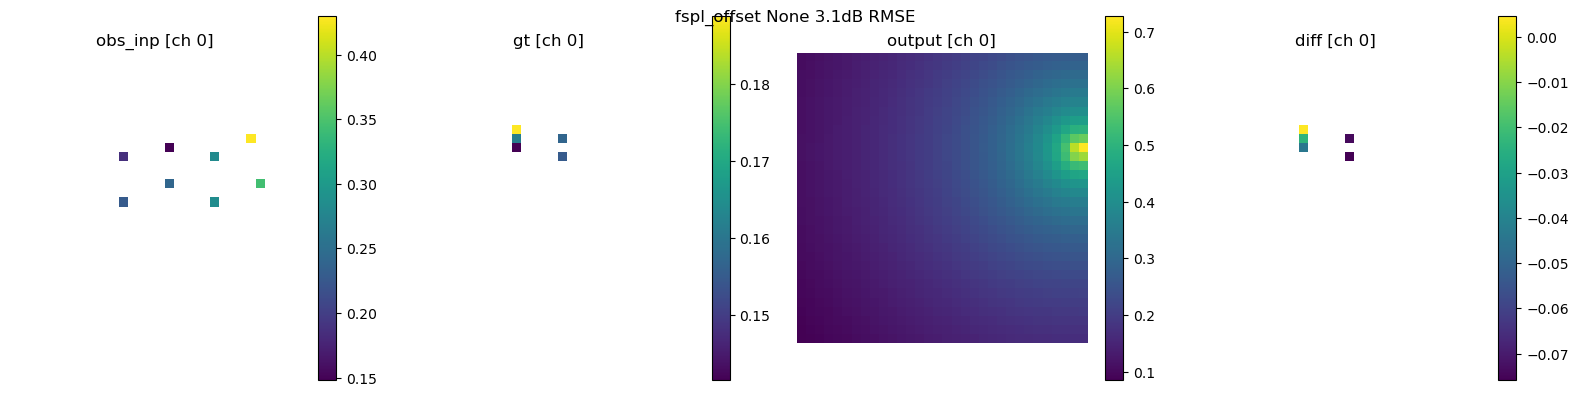

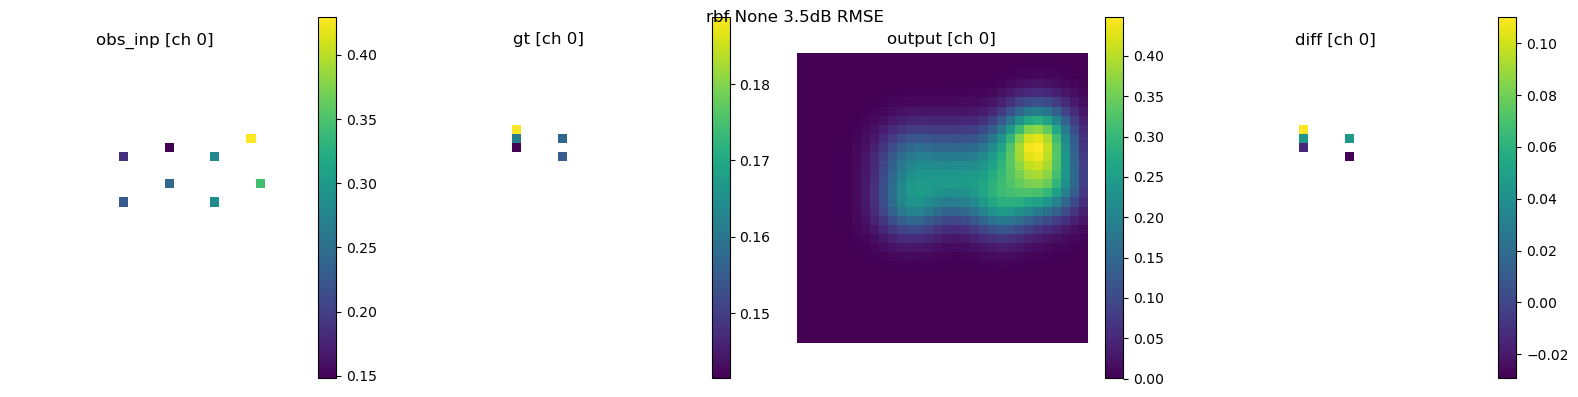

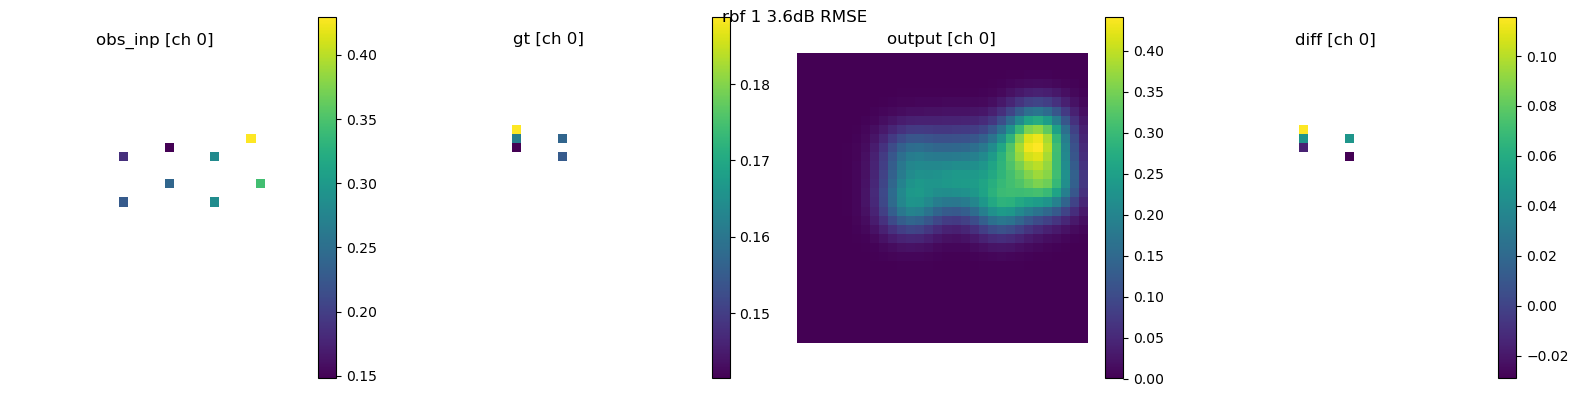

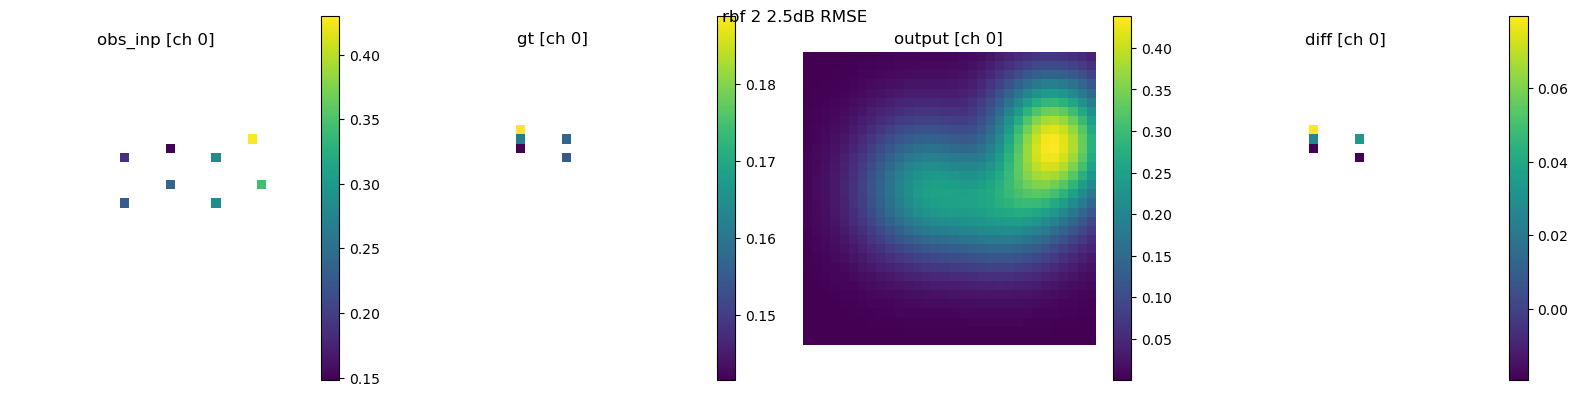

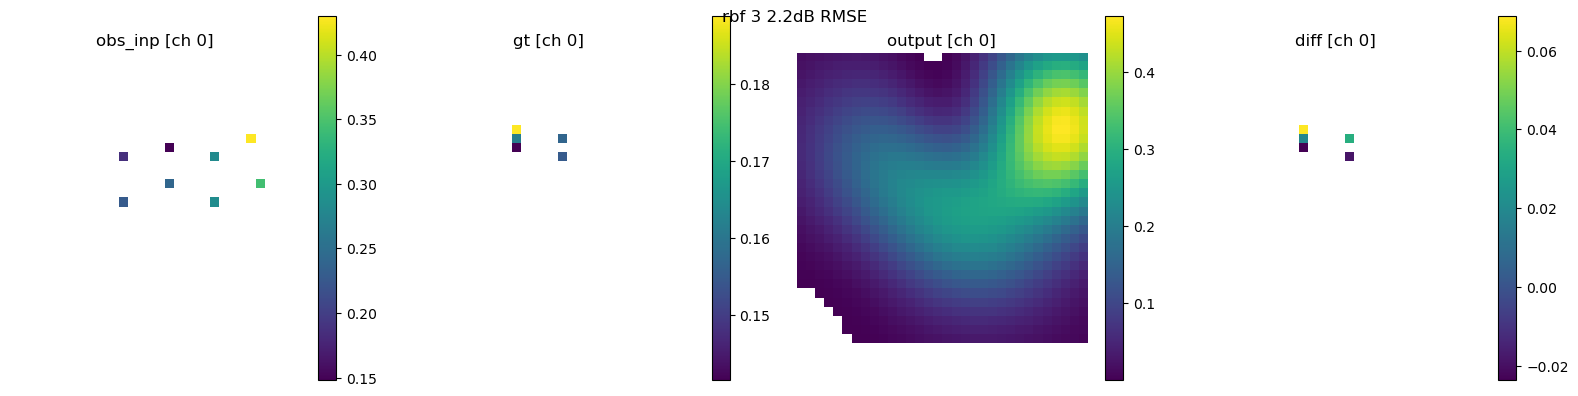

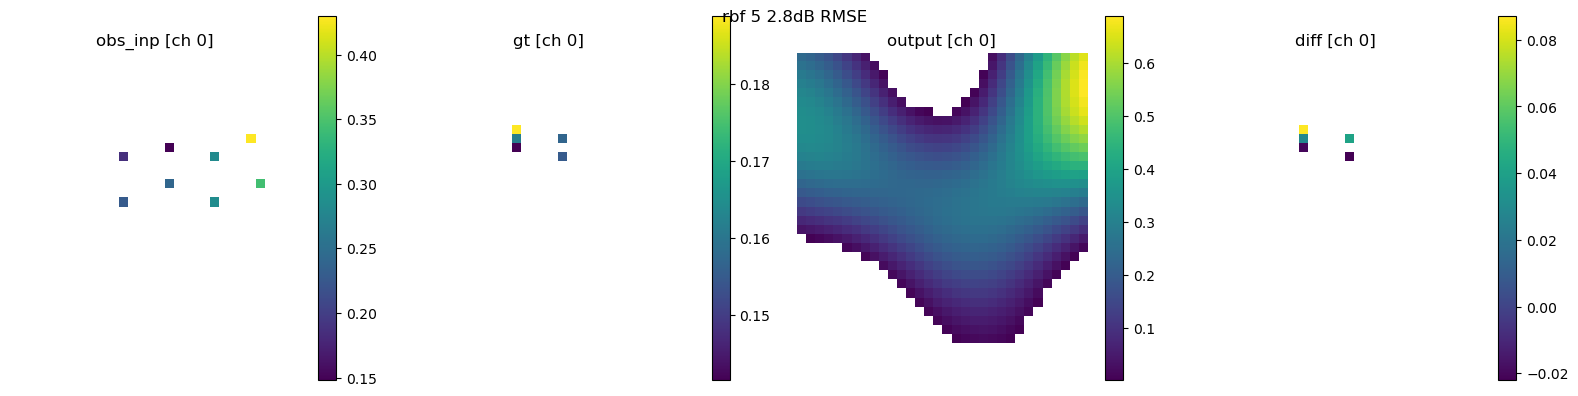

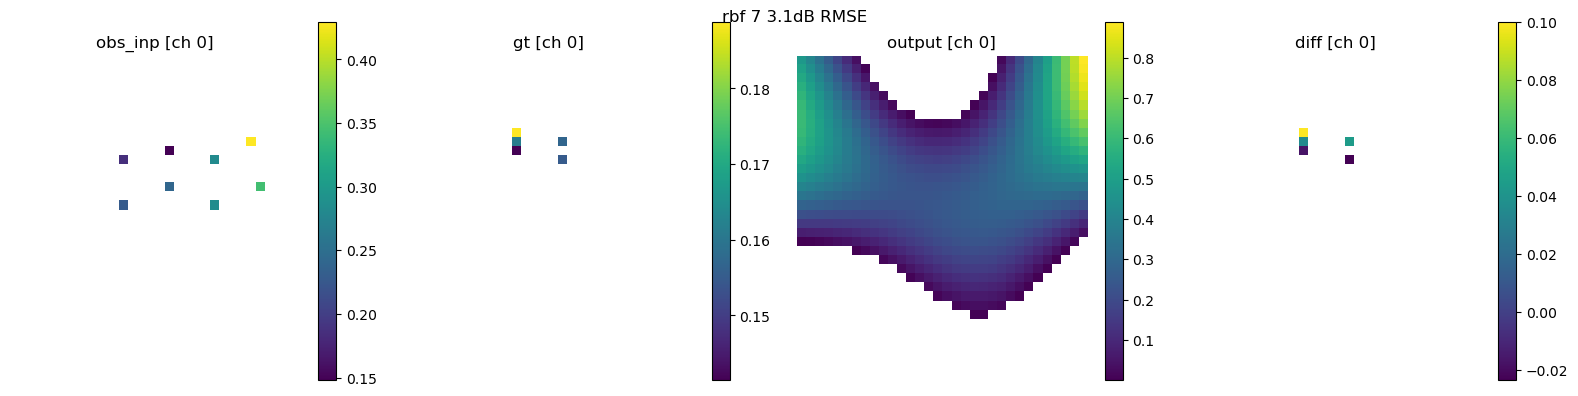

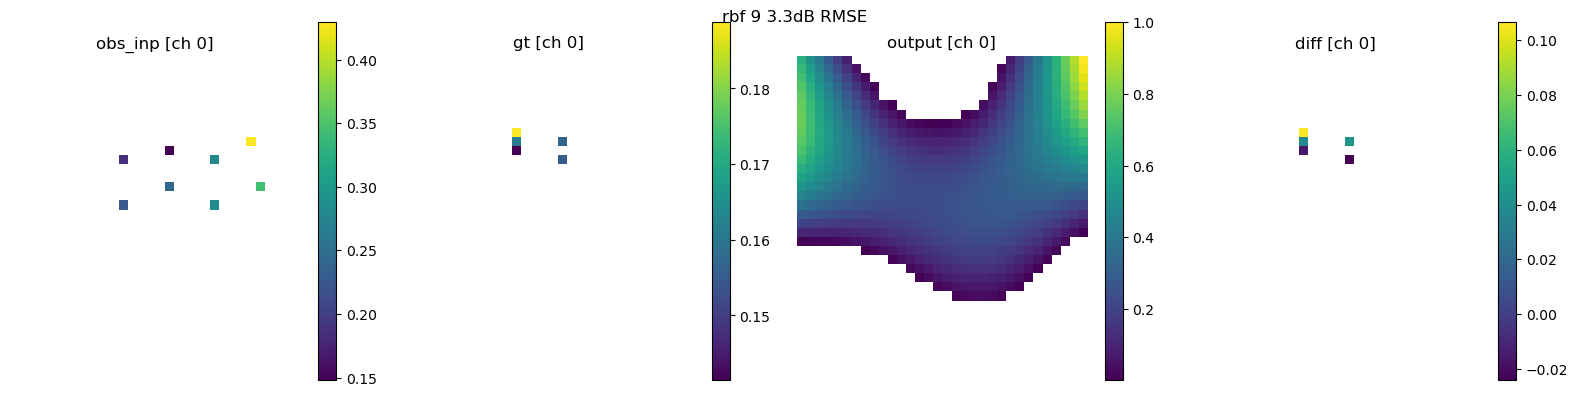

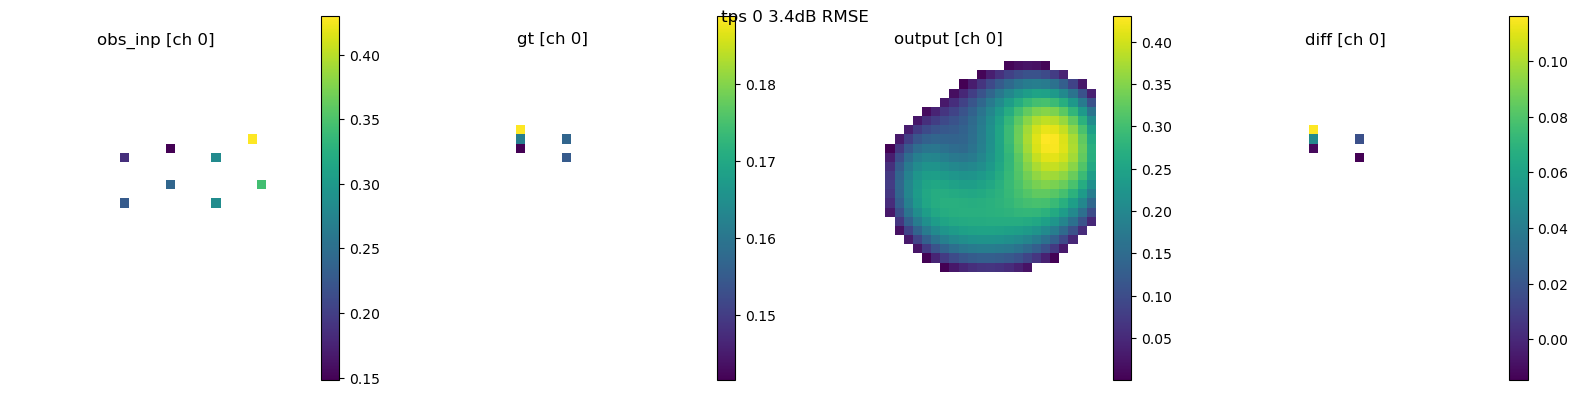

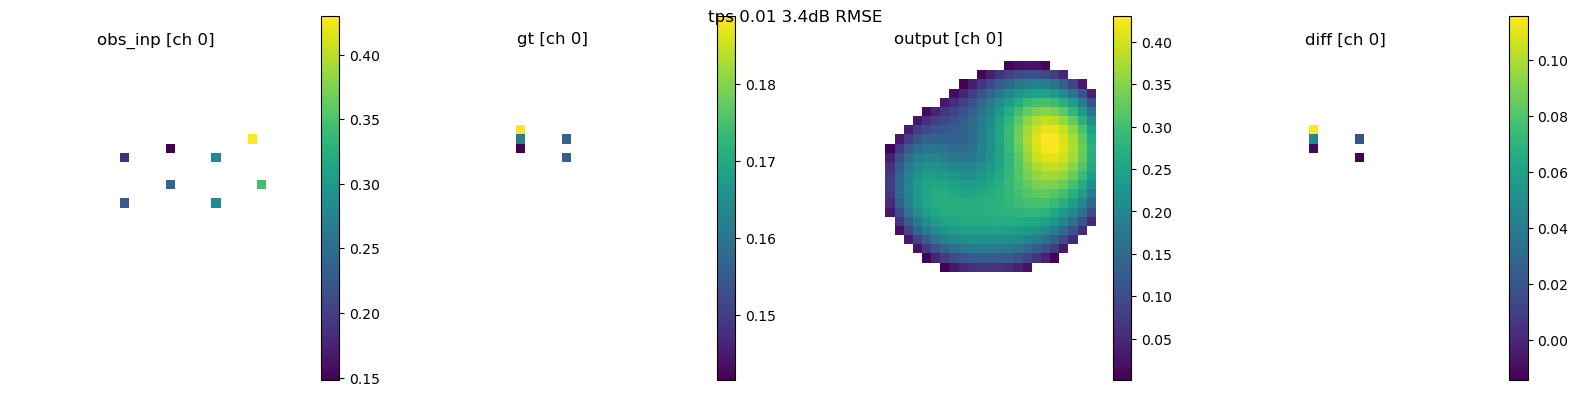

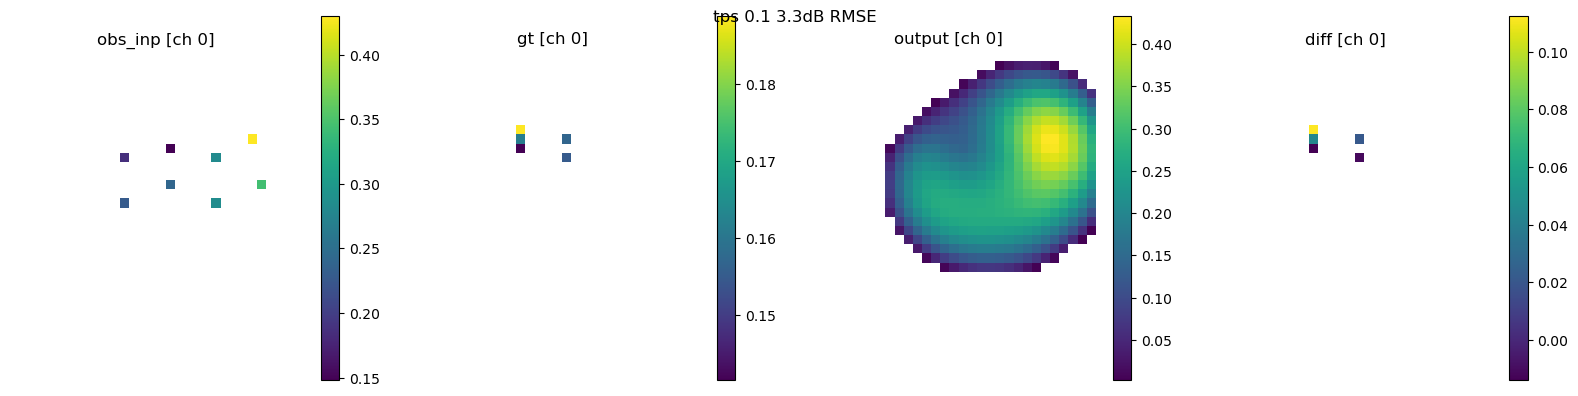

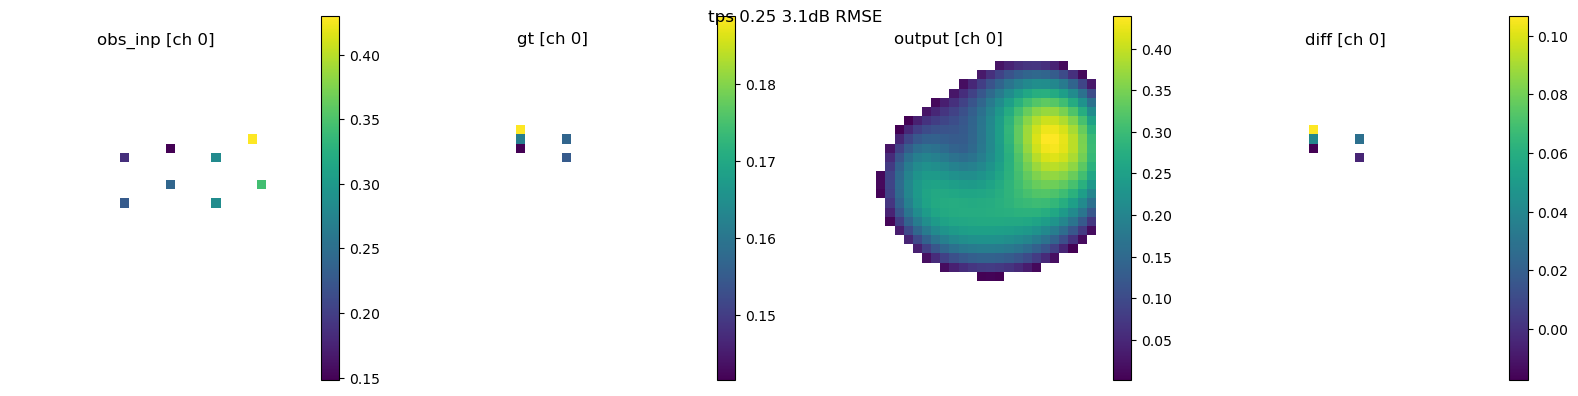

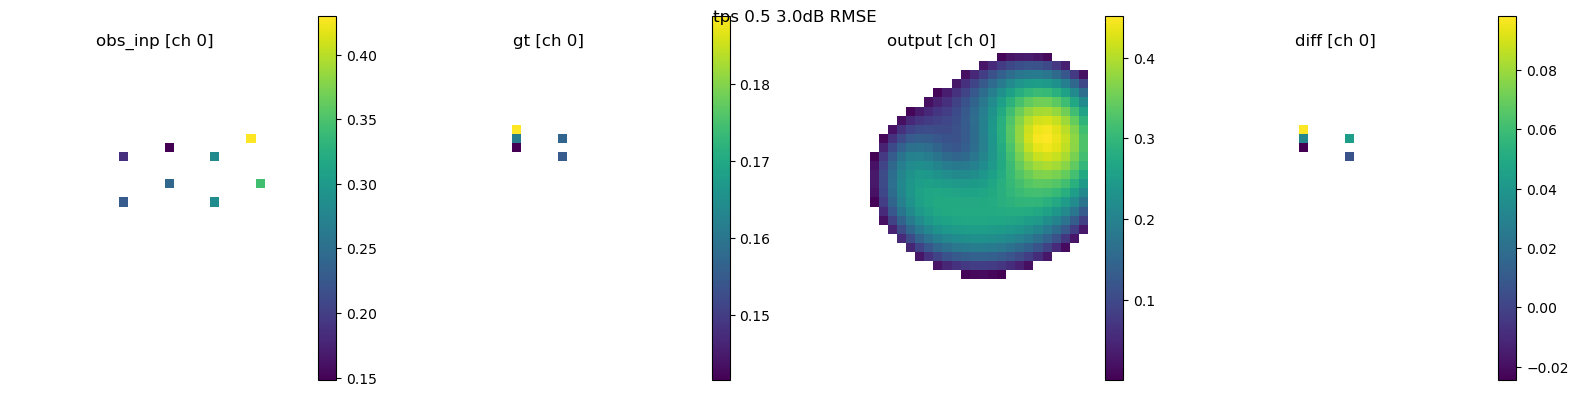

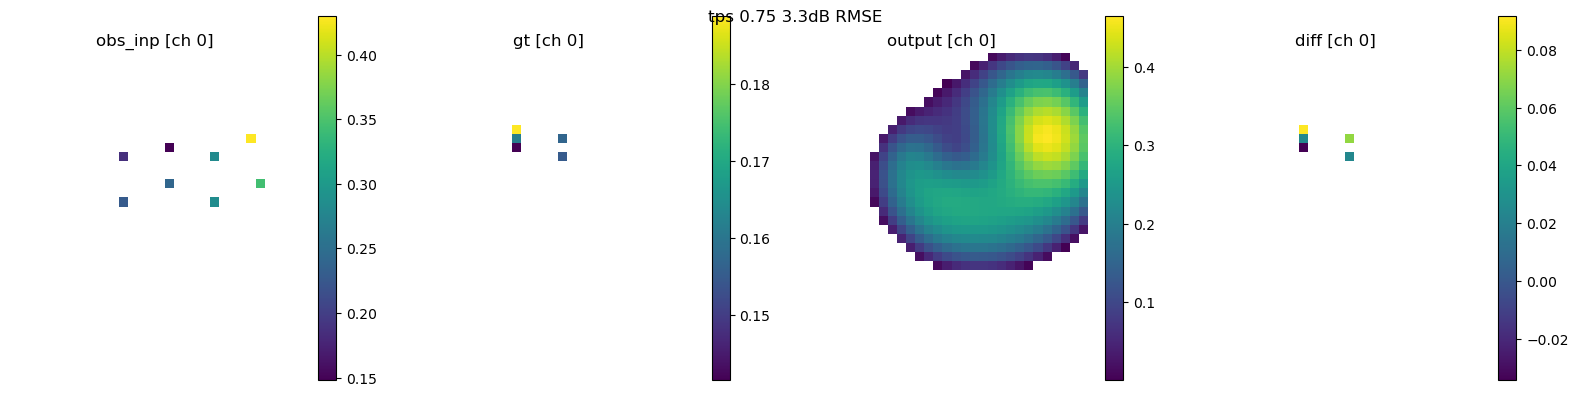

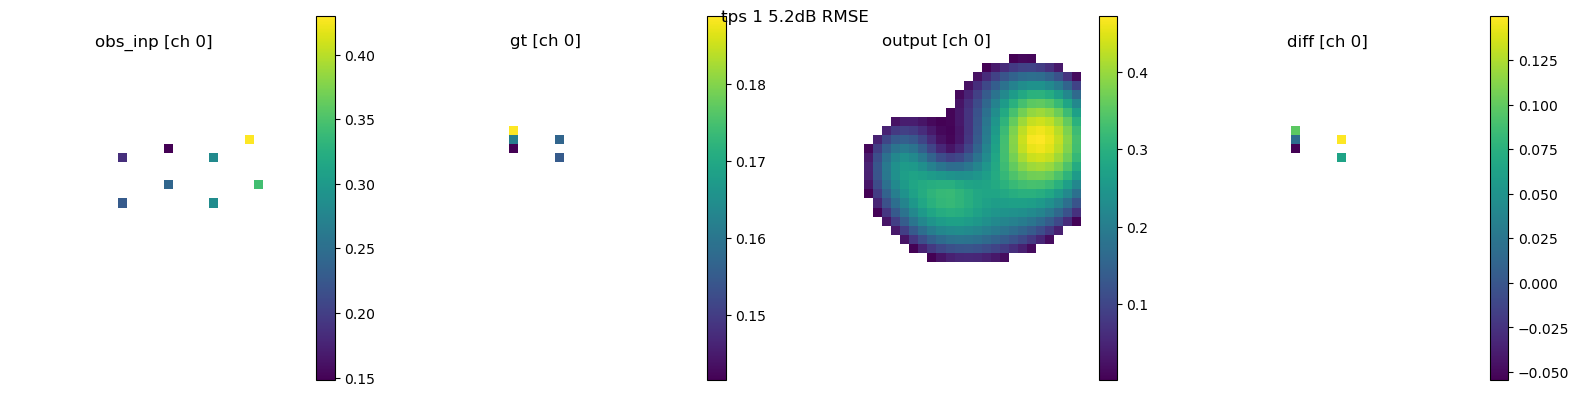

In [ ]:
tx_id = 3

n_test = 500
for name, (fun, param_list) in methods.items():
    for param in param_list:
        print(f'\n{name=}\t{param=}')
        metrics = defaultdict(float)
        for sample_id in range(n_test):
            obs_inp, gt, gt_mask, obs_mask, tx_coords = extract_data(
                observation_areas=[(data_old, [f'MeasurementArea_{k}' for k in [1,2,3,4,7,8]]),
                                    (data_new_mit, [f'MeasurementArea_{k}-mit_Abschattung' for k in [5, 6]])
                                    ],
                test_areas=[(data_new_mit, [f'MeasurementArea_{k}-mit_Abschattung' for k in [5, 6]])],
                percentage_threshold=50,
                tx_id=tx_id,
                seed=sample_id
            )
            output = fun(inputs=obs_inp, observation_mask=obs_mask, tx_coords=tx_coords, pl_trnc=pl_trnc, pl_max=pl_max, param=param)
            diff = (gt - output) * gt_mask
            err = calc_loss_with_mask(pred=output, target=gt, mask=gt_mask, observation_mask=obs_mask, alpha=1, metrics=metrics)
        print_metricsTest(metrics=metrics, epoch_samples=n_test, phase='test', pl_max=pl_max, pl_trnc=pl_trnc, log_name=None)
        plot_dict(dict(obs_inp=obs_inp, gt=gt, output=output, diff=diff), in_batch_id=0, close_fig=False, suptitle=f'{name} {param} {torch.sqrt(err) * (71-12):.1f}dB RMSE')



test: squared_errors_summed: 0.013941, valid_pixels_summed: 5.000000, loss: 0.002788, RMSE in dB: 3.115398
test: squared_errors_summed: 0.014221, valid_pixels_summed: 5.000000, loss: 0.002844, RMSE in dB: 3.146515


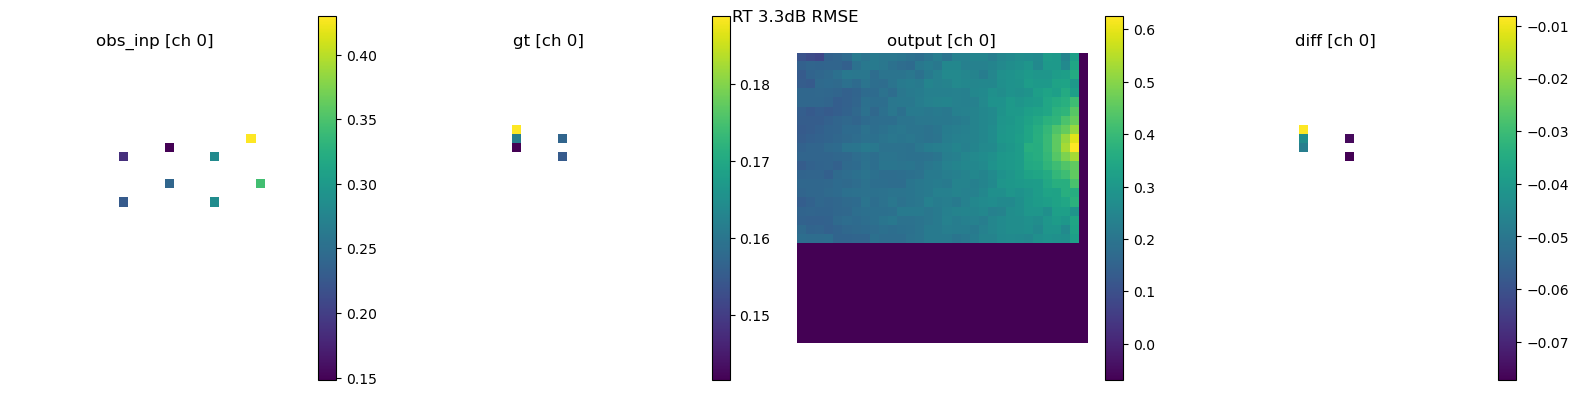

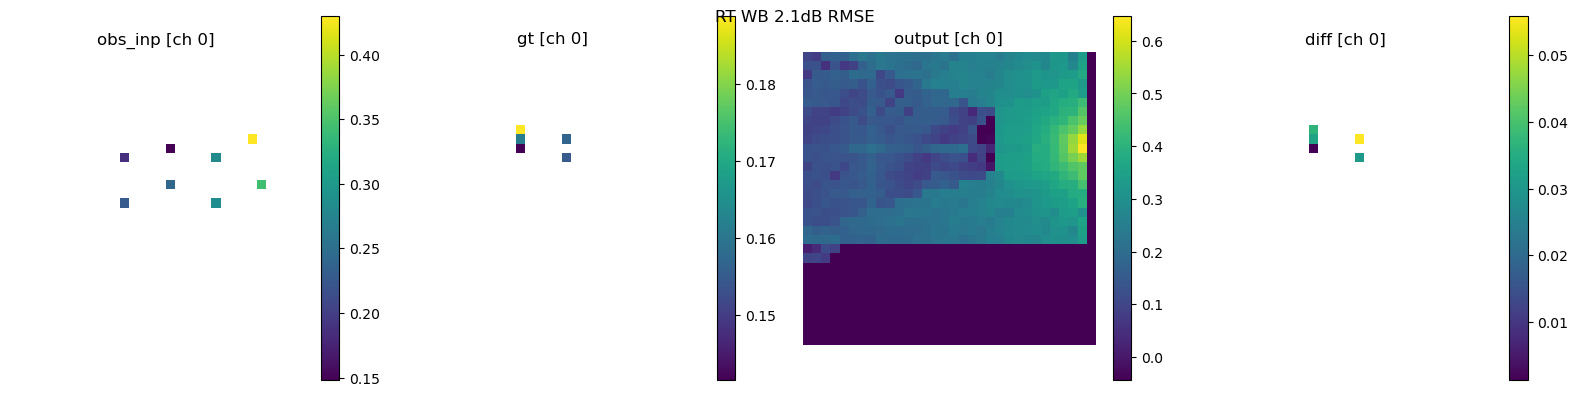

In [ ]:
tensors_plot = []

metrics_rt = defaultdict(float)
metrics_rt_wb = defaultdict(float)
for sample_id in range(n_test):
    obs_inp, gt, gt_mask, obs_mask, tx_coords = extract_data(
        observation_areas=[(data_old, [f'MeasurementArea_{k}' for k in [1,2,3,4,7,8]]),
                            (data_new_mit, [f'MeasurementArea_{k}-mit_Abschattung' for k in [5, 6]])
                            ],
        test_areas=[(data_new_mit, [f'MeasurementArea_{k}-mit_Abschattung' for k in [5, 6]])],
        percentage_threshold=50,
        tx_id=tx_id,
        seed=sample_id
    )

    output = get_rm_adjusted(inputs=obs_inp, observation_mask=obs_mask, rm=rms_rt[tx_id])
    diff = (gt - output) * gt_mask
    err = calc_loss_with_mask(pred=output, target=gt, mask=gt_mask, observation_mask=obs_mask, alpha=1, metrics=metrics_rt)

    output_whiteboard = get_rm_adjusted(inputs=obs_inp, observation_mask=obs_mask, rm=rms_rt_whiteboard[tx_id])
    diffwb = (gt - output_whiteboard) * gt_mask
    errwb = calc_loss_with_mask(pred=output_whiteboard, target=gt, mask=gt_mask, observation_mask=obs_mask, alpha=1, metrics=metrics_rt_wb)

print_metricsTest(metrics=metrics_rt, epoch_samples=n_test, phase='test', pl_max=pl_max, pl_trnc=pl_trnc, log_name=None)
print_metricsTest(metrics=metrics_rt_wb, epoch_samples=n_test, phase='test', pl_max=pl_max, pl_trnc=pl_trnc, log_name=None)

plot_dict(dict(obs_inp=obs_inp, gt=gt, output=output, diff=diff), in_batch_id=0, close_fig=False, suptitle=f'RT {torch.sqrt(err) * (71-12):.1f}dB RMSE')
plot_dict(dict(obs_inp=obs_inp, gt=gt, output=output_whiteboard, diff=diffwb), in_batch_id=0, close_fig=False, suptitle=f'RT WB {torch.sqrt(errwb) * (71-12):.1f}dB RMSE')

tensors_plot.extend([obs_inp[0], gt[0], output[0], output_whiteboard[0]])



Binary, SNDA	seminar_room_2501
test: squared_errors_summed: 0.006515, valid_pixels_summed: 5.000000, loss: 0.001303, RMSE in dB: 2.129664


Binary, SNDA	seminar_room_2511_wb
test: squared_errors_summed: 0.002408, valid_pixels_summed: 5.000000, loss: 0.000482, RMSE in dB: 1.294865


Binary	seminar_room_2501
test: squared_errors_summed: 0.012990, valid_pixels_summed: 5.000000, loss: 0.002598, RMSE in dB: 3.007278


Binary	seminar_room_2511_wb
test: squared_errors_summed: 0.014821, valid_pixels_summed: 5.000000, loss: 0.002964, RMSE in dB: 3.212196


No Environment	seminar_room_2501
test: squared_errors_summed: 0.003939, valid_pixels_summed: 5.000000, loss: 0.000788, RMSE in dB: 1.655964


No Environment	seminar_room_2511_wb
test: squared_errors_summed: 0.003939, valid_pixels_summed: 5.000000, loss: 0.000788, RMSE in dB: 1.655964


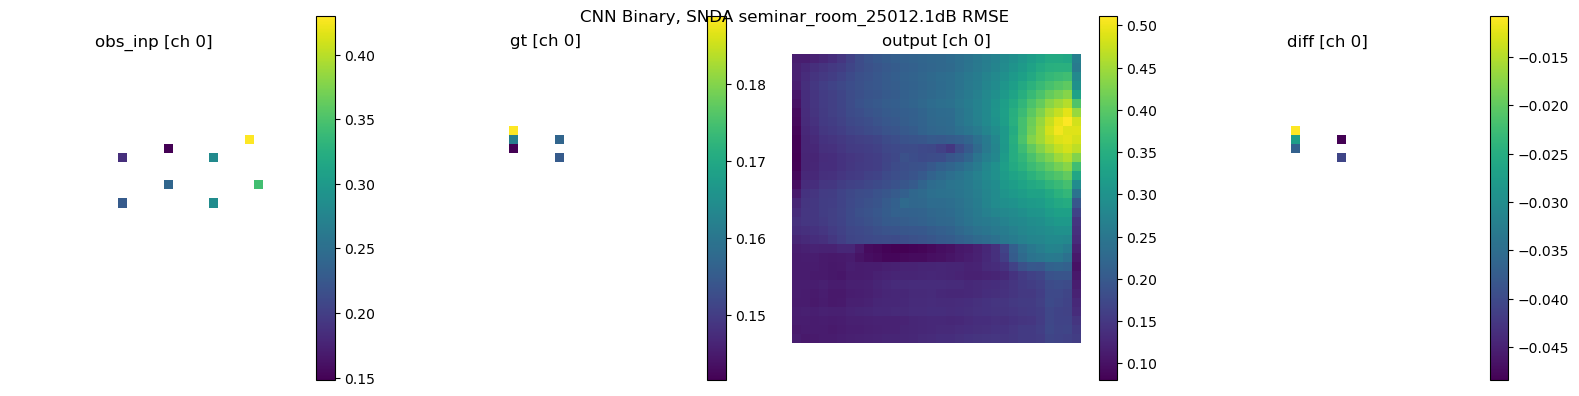

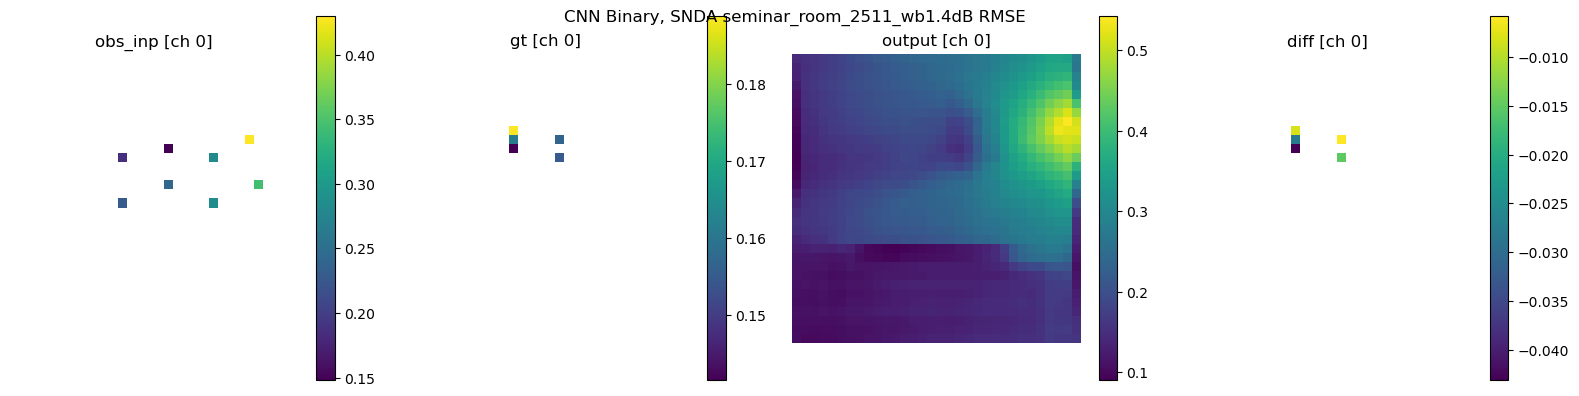

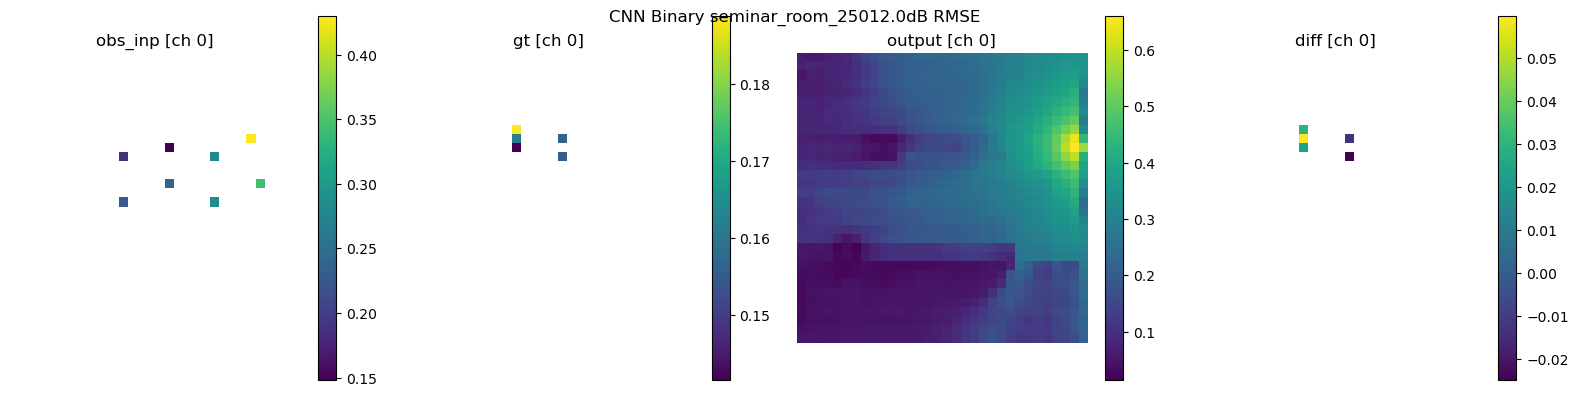

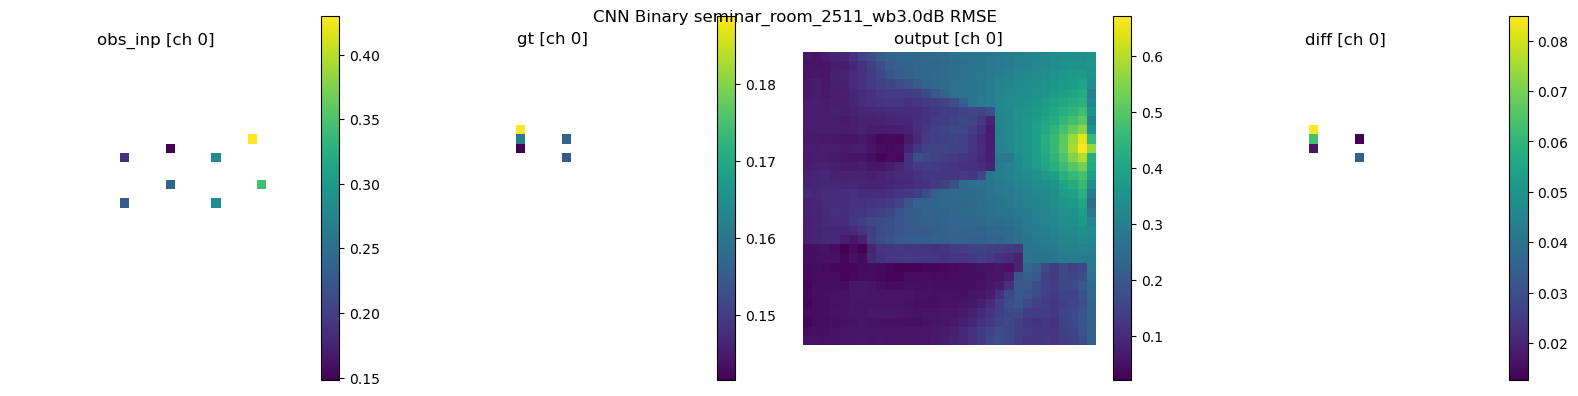

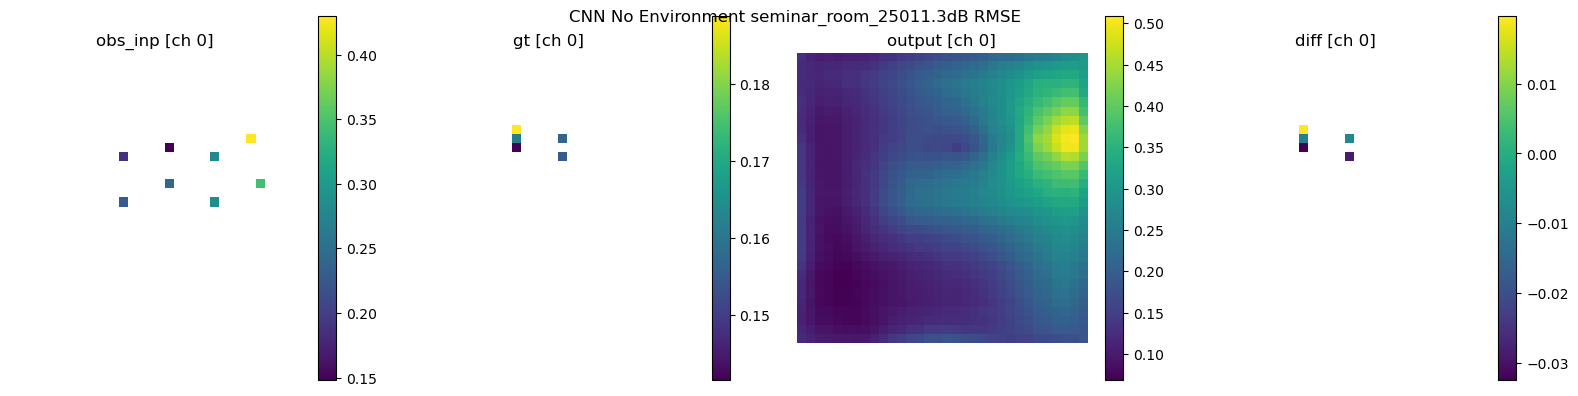

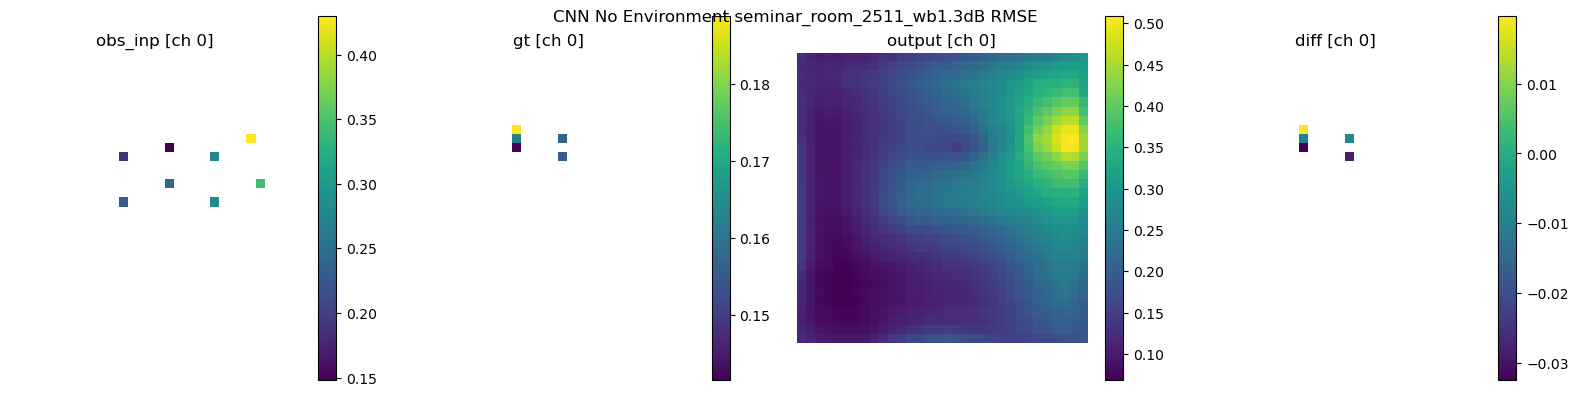

In [22]:
with torch.no_grad():

    for (model_dir, name) in [
            (Path('logs/RadioNetAnySize/20251210-12:17:45'), 'Binary, SNDA'),
            (Path('logs/RadioNetAnySize/20251210-12:17:36'), 'Binary'),
            (Path('logs/RadioNetAnySize/20251110-12:25:12'), 'No Environment'),
        ]:

        try:
            weights = torch.load(model_dir / 'BestModel.pt', weights_only=True)
        except FileNotFoundError as e:
            print(str(model_dir), e)
            continue

        for k, v in weights.items():
            if not 'conv' in k:
                continue
            else:
                in_ch = v.shape[1]
                break

        with open(model_dir / 'parameters.json', 'r') as f:
            config = json.load(f)

        model = RadioNetAnySize(inputs=in_ch, initial_downsampling=int(config['raster_size'] / 32))
        model.load_state_dict(weights)
        for dataset_dir in [Path('dataset/seminar_room_2501'), Path('dataset/seminar_room_2511_wb')]:#, Path('dataset/seminar_room_2511_wb_wood')]:
            print(f'\n\n{name}\t{dataset_dir.stem}')
            metrics = defaultdict(float)
            for sample_id in range(n_test):
                obs_inp, gt, gt_mask, obs_mask, tx_coords = extract_data(
                    # observation_areas=[(data_old, [f'MeasurementArea_{k}' for k in [1,2,3,4,7,8]])],
                    # test_areas=[(data_old, [f'MeasurementArea_{k}' for k in [5, 6]])],
                    # test_areas=[(data_new_mit, [f'MeasurementArea_{k}-mit_Abschattung' for k in [5, 6]])],
                    observation_areas=[(data_old, [f'MeasurementArea_{k}' for k in [1,2,3,4,7,8]]),
                                        (data_new_mit, [f'MeasurementArea_{k}-mit_Abschattung' for k in [5, 6]])
                                        ],
                    # test_areas=[(data_old, [f'MeasurementArea_{k}' for k in [5, 6]])],
                    test_areas=[(data_new_mit, [f'MeasurementArea_{k}-mit_Abschattung' for k in [5, 6]])],
                    percentage_threshold=50,
                    tx_id=tx_id,
                    seed=sample_id
                )
                inputs_cnn = get_model_inputs(config, tx_id, obs_inp, dataset_dir=dataset_dir)
                output_cnn = model(inputs_cnn)
                diff = (gt - output_cnn) * gt_mask
                err = calc_loss_with_mask(pred=output_cnn, target=gt, mask=gt_mask, observation_mask=obs_mask, alpha=1, metrics=metrics)
            print_metricsTest(metrics=metrics, epoch_samples=n_test, phase='test', pl_max=pl_max, pl_trnc=pl_trnc, log_name=None)
            plot_dict(dict(obs_inp=obs_inp, gt=gt, output=output_cnn, diff=diff), in_batch_id=0, close_fig=False, suptitle=f'CNN {name} {dataset_dir.stem}{torch.sqrt(err) * (71-12):.1f}dB RMSE')
            tensors_plot.append(output_cnn[0])


# Save Plotted Images

/tmp/ipykernel_2071978/2884492561.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


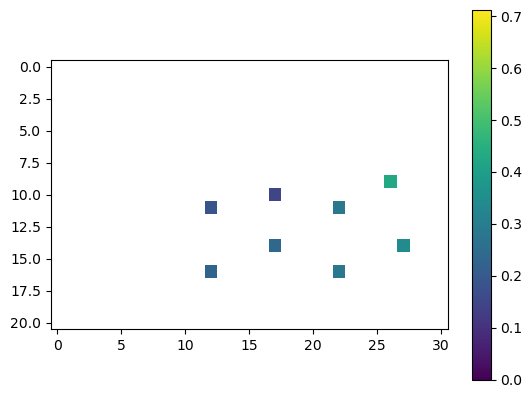

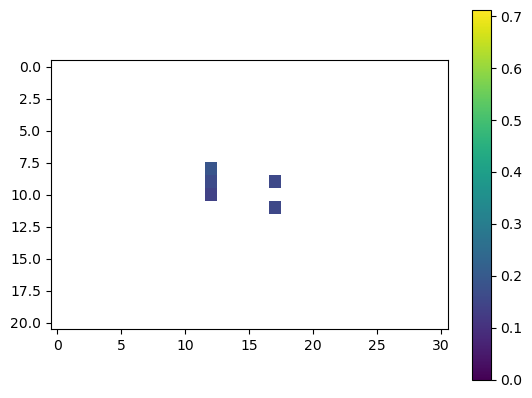

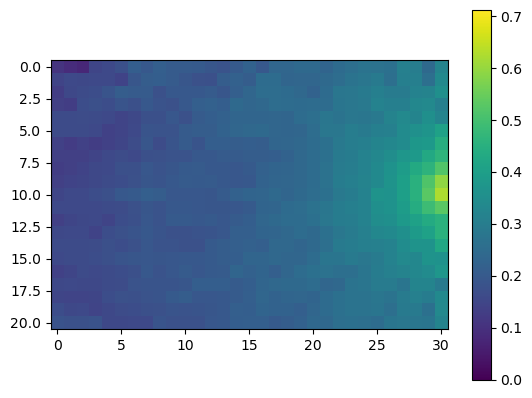

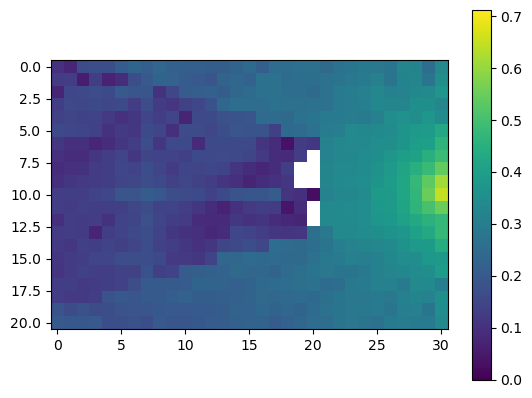

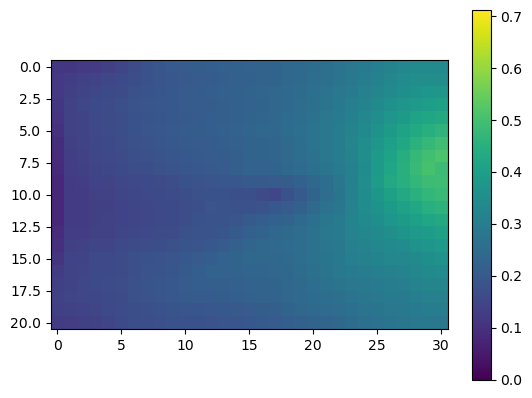

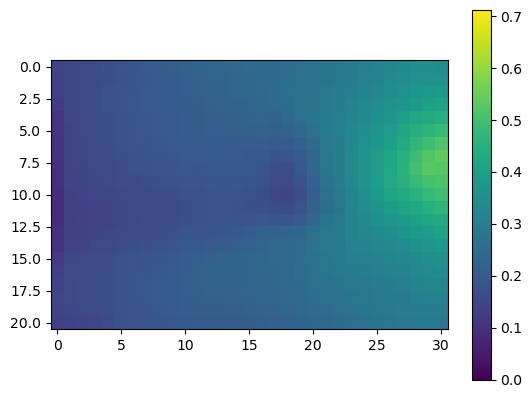

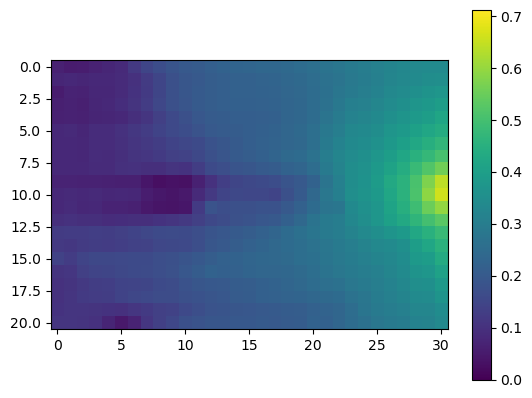

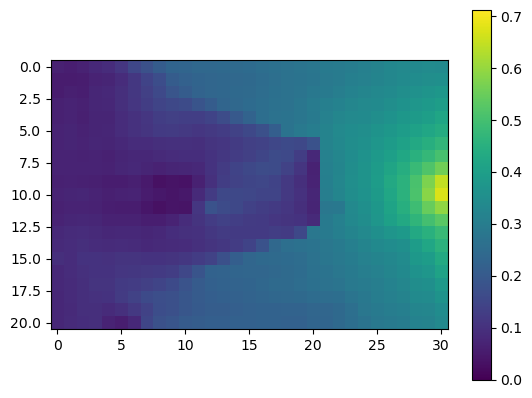

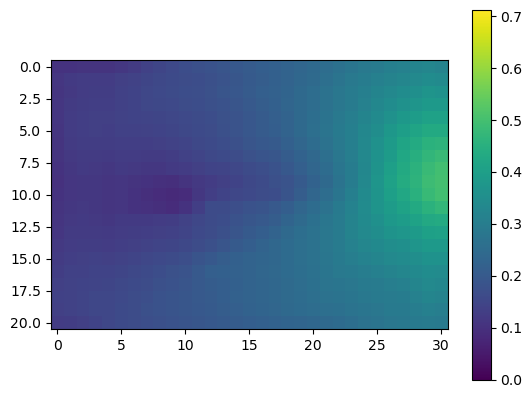

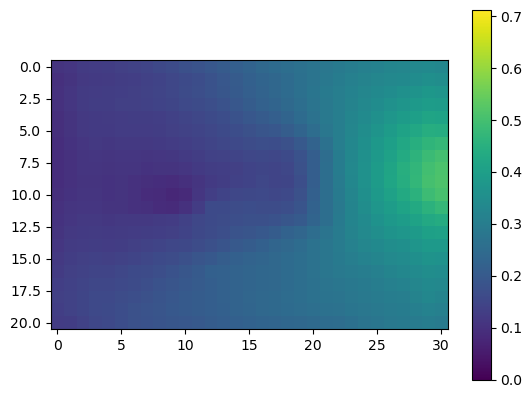

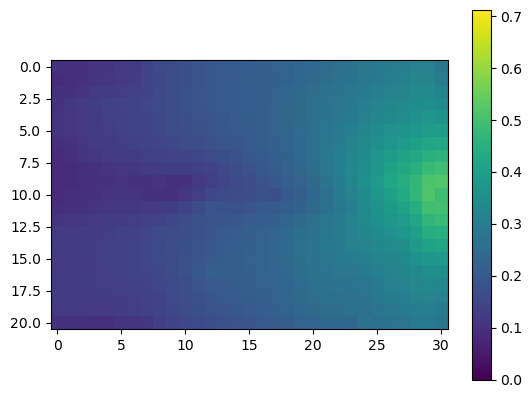

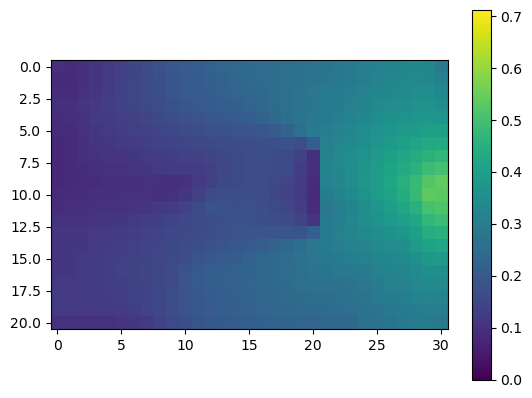

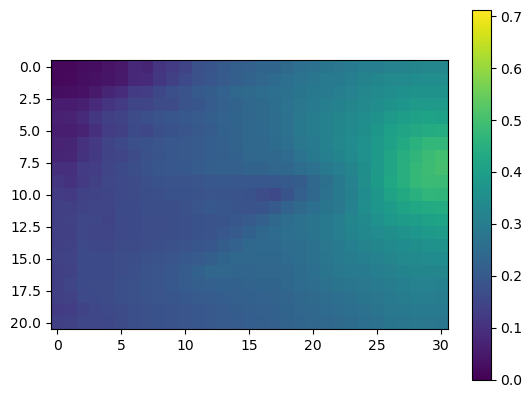

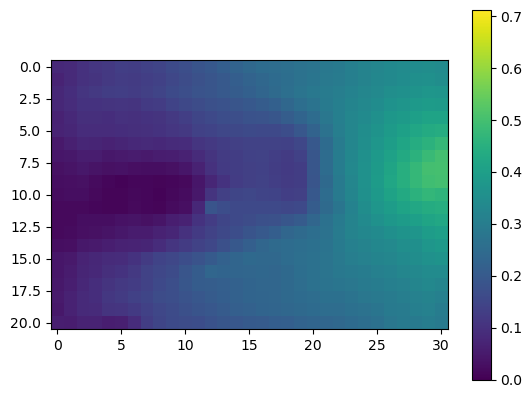

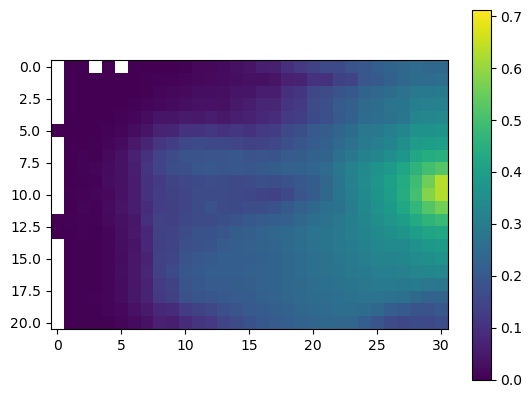

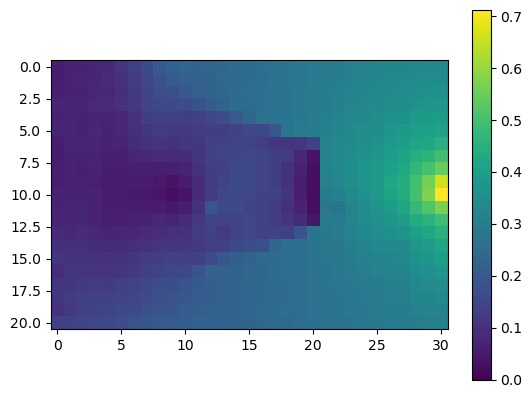

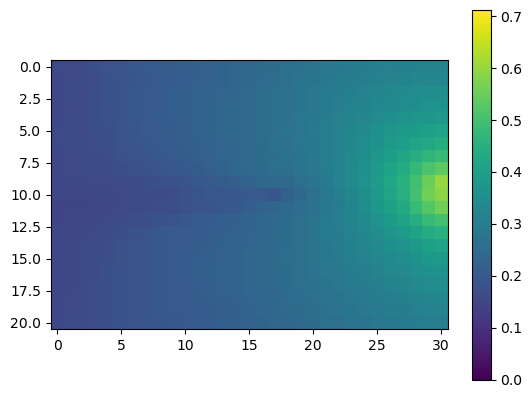

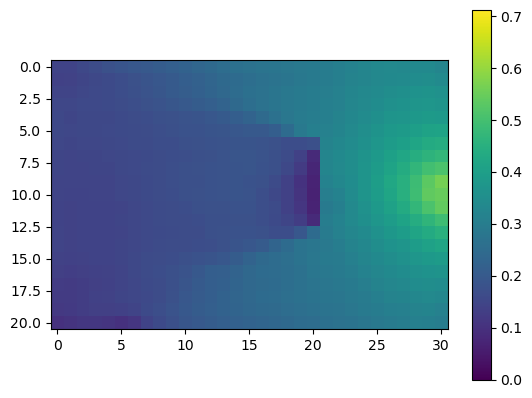

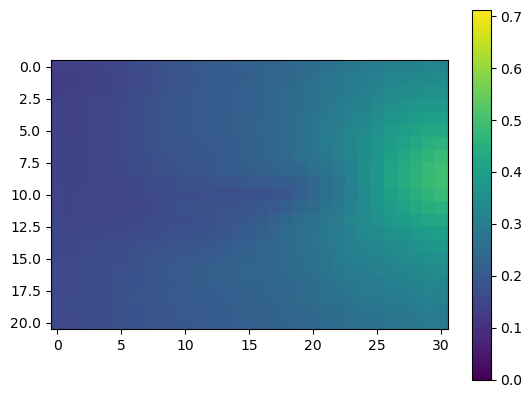

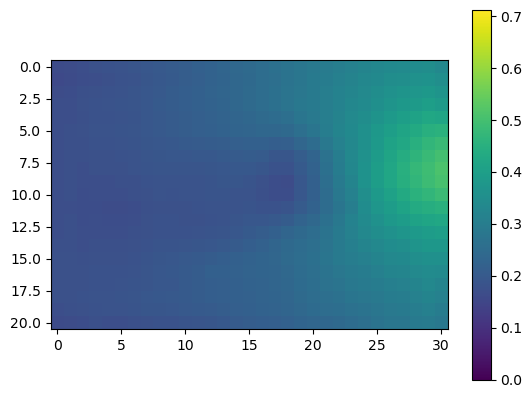

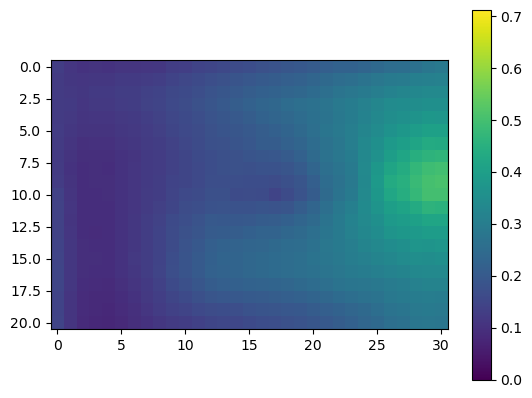

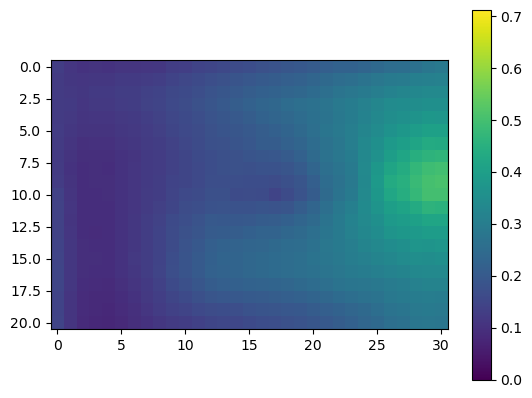

In [16]:
from matplotlib import cm

def imgsave(fname: Path, arr: np.ndarray, vmin: float = 0, vmax: float = 1, cmap="viridis"):
    a = arr.squeeze()
    assert a.ndim == 2
    N, M = a.shape

    # normalize to [0,1]
    x = np.clip((a - vmin) / (vmax - vmin), 0, 1)

    # get colormap and convert to RGBA in [0,255]
    rgba = cm.get_cmap(cmap)(x)          # float32 in [0,1]
    rgb = (rgba[..., :3] * 255).astype(np.uint8)


    # write exact NxN RGB image
    img = Image.fromarray(rgb.repeat(10, 0).repeat(10, 1))
    
    img.save(fname)

def nanmax(tensor : torch.Tensor):
    min_value = torch.finfo(tensor.dtype).min
    output = tensor.nan_to_num(min_value).max()
    return output


def nanmin(tensor : torch.Tensor):
    max_value = torch.finfo(tensor.dtype).max
    output = tensor.nan_to_num(max_value).min()
    return output


vmin = max(min(nanmin(t) for t in tensors_plot), 0)
vmax = min(max(nanmax(t) for t in tensors_plot), 1)

for t in tensors_plot:
    th = t.squeeze()[:21, :31]
    plt.figure()
    plt.imshow(torch.where(th <= 0, torch.nan, th), vmax=vmax, vmin=vmin)
    plt.colorbar()


In [17]:
for k in range(len(tensors_plot)):
    tensors_plot[k] = tensors_plot[k].squeeze()[:21, :31]

In [18]:
out_dir = Path('figs_paper/seminar_room')
out_dir.mkdir(exist_ok=True, parents=True)

In [19]:
imgsave(out_dir / 'observations.png', torch.where(tensors_plot[0] > 0, tensors_plot[0], torch.nan), vmin=vmin, vmax=vmax)
imgsave(out_dir / 'gt.png', torch.where(tensors_plot[1] > 0, tensors_plot[1], torch.nan), vmin=vmin, vmax=vmax)
imgsave(out_dir / 'rt.png', tensors_plot[2], vmin=vmin, vmax=vmax)
imgsave(out_dir / 'rt_wb.png', tensors_plot[3], vmin=vmin, vmax=vmax)
imgsave(out_dir / 'cnn.png', tensors_plot[4], vmin=vmin, vmax=vmax)
imgsave(out_dir / 'cnn_wb.png', tensors_plot[5], vmin=vmin, vmax=vmax)

/tmp/ipykernel_2071978/2884492561.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rgba = cm.get_cmap(cmap)(x)          # float32 in [0,1]


/tmp/ipykernel_2071978/3392193126.py:5: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 1 Axes> than <Figure size 640x480 with 2 Axes> which fig.colorbar is called on.
  plt.colorbar(mpb,ax=ax)


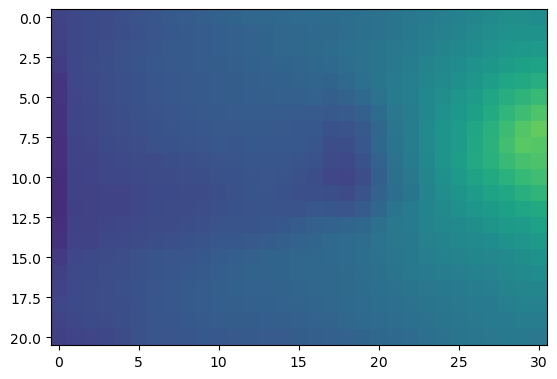

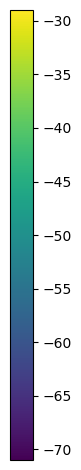

In [20]:
gray_dBm(tensors_plot[5], pl_trnc=-71, pl_max=-12)
mpb = plt.imshow(gray_dBm(tensors_plot[5], pl_trnc=-71, pl_max=-12), vmin=gray_dBm(vmin, pl_trnc=-71, pl_max=-12), vmax=gray_dBm(vmax, pl_trnc=-71, pl_max=-12))

fig,ax = plt.subplots()
plt.colorbar(mpb,ax=ax)
ax.remove()
plt.tight_layout()
plt.savefig(out_dir / 'colorbar.png', bbox_inches='tight')